## Read me

1. please run the program from top to bottom
2. if you have the data input pickle files, you can run the code in the middle


### Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
# Author: Robert Guthrie

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

### Read data in pandas

In [2]:
def read_data(file_name, n_sample):
    f = open(file_name)
    documents = f.readlines()

    input_data = []
    target_data = []

    temp1 = []
    temp2 = []
    for i in documents:
        if i == '\n':
            input_data.append(temp1)
            target_data.append(temp2)
            temp1 = []
            temp2 = []
        else:
            temp1.append(i.replace('\n','').split(' ')[0].lower())
            temp2.append(i.replace('\n','').split(' ')[3])
    return input_data[:n_sample], target_data[:n_sample]


In [3]:
pathCode = os.path.abspath('.')
pathData= fr'{pathCode}/2020-comp5046-a2/'  # change the file name if you need other input data

df_train = pd.read_csv(fr'{pathData}'+'train.csv')
df_val = pd.read_csv(fr'{pathData}'+'val.csv')
df_test = pd.read_csv(fr'{pathData}'+'test.csv')

In [4]:
df_train

,Sentence,NER
0,-docstart-,O
1,eu rejects german call to boycott british lamb .,I-ORG O I-MISC O O O I-MISC O O
2,peter blackburn,I-PER I-PER
3,brussels 1996-08-22,I-LOC O
4,the european commission said on thursday it di...,O I-ORG I-ORG O O O O O O I-MISC O O O O O I-M...
...,...,...
2995,hovercrafts will soon be plying the waters of ...,O O O O O O O O O I-LOC O O O O O O O O O O O ...
2996,"two russian-built hovercrafts , capable of car...",O I-MISC O O O O O O O O O O O O O O O O O O O...
2997,the use of riverways in the region has been ma...,O O O O O O O O O O O O O O O O O O I-LOC O O ...
2998,-docstart-,O


### Data Preprocessing

#### data preprocessing - tokenization

In [5]:
# import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import nltk

stemmer = SnowballStemmer("english")
stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
def tokenize_text(text):
    return [w for w in w_tokenizer.tokenize(text)]


def transform_text(series):
    series = series.apply(lambda x: ' '.join([word for word in x.split()]))
    series = series.apply(tokenize_text)

    return series

def transform_text2(series):
    series = series.str.replace('-','0')

    return series

df_train['Sentence_processed'] = transform_text(df_train['Sentence'])
df_val['Sentence_processed'] = transform_text(df_val['Sentence'])
df_test['Sentence_processed'] = transform_text(df_test['Sentence'])

df_train['Sentence_processed_forParsing'] = transform_text2(df_train['Sentence'])
df_val['Sentence_processed_forParsing'] = transform_text2(df_val['Sentence'])
df_test['Sentence_processed_forParsing'] = transform_text2(df_test['Sentence'])

df_train['NER_processed'] = transform_text(df_train['NER'])
df_val['NER_processed'] = transform_text(df_val['NER'])
#df_test['NER_processed'] = transform_text(df_test['NER'])

df_train.head()

,Sentence,NER,Sentence_processed,Sentence_processed_forParsing,NER_processed
0,-docstart-,O,[-docstart-],0docstart0,[O]
1,eu rejects german call to boycott british lamb .,I-ORG O I-MISC O O O I-MISC O O,"[eu, rejects, german, call, to, boycott, briti...",eu rejects german call to boycott british lamb .,"[I-ORG, O, I-MISC, O, O, O, I-MISC, O, O]"
2,peter blackburn,I-PER I-PER,"[peter, blackburn]",peter blackburn,"[I-PER, I-PER]"
3,brussels 1996-08-22,I-LOC O,"[brussels, 1996-08-22]",brussels 1996008022,"[I-LOC, O]"
4,the european commission said on thursday it di...,O I-ORG I-ORG O O O O O O I-MISC O O O O O I-M...,"[the, european, commission, said, on, thursday...",the european commission said on thursday it di...,"[O, I-ORG, I-ORG, O, O, O, O, O, O, I-MISC, O,..."


### Word Embedding - Embedding technique 1

#### Generate word_to_ix and tag_to_ix

In [6]:
words_data = list(df_train['Sentence_processed'].values)+list(df_val['Sentence_processed'].values)+list(df_test['Sentence_processed'].values)
word_to_ix = {}

for sentence in words_data:
    for word in sentence:
        word = word.lower()
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
            
word_list = list(word_to_ix.keys())

START_TAG = "<START>"
STOP_TAG = "<STOP>"


tags_data = list(df_train['NER_processed'].values)+list(df_val['NER_processed'].values)

tag_to_ix = {START_TAG:0, STOP_TAG:1}

for tags in tags_data:
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

#### Generate Word Embedding Matrix

In [7]:
import gensim.downloader as api
word_emb_model = api.load("glove-twitter-25") 

EMBEDDING_DIM = 25

embedding_matrix = []
for word in word_list:
    try:
        embedding_matrix.append(word_emb_model.wv[word])
    except:
        embedding_matrix.append([0]*EMBEDDING_DIM)
embedding_matrix = np.array(embedding_matrix)
embedding_matrix.shape

C:\Users\ANPC\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


(13972, 25)

#### convert dataset into idxs

In [23]:
def to_index(data, to_ix):
    input_index_list = []
    for sent in data:
        input_index_list.append([to_ix[w] for w in sent])
    return input_index_list

df_train['output_index'] = to_index(df_train['NER_processed'].values, tag_to_ix)
df_val['output_index'] = to_index(df_val['NER_processed'].values, tag_to_ix)
#df_test['train_output_index'] = to_index(df_test['NER_processed'].values, tag_to_ix)


df_train['input_word_index'] = to_index(df_train['Sentence_processed'].values, word_to_ix)
df_val['input_word_index'] = to_index(df_val['Sentence_processed'].values, word_to_ix)
df_test['input_word_index'] = to_index(df_test['Sentence_processed'].values, word_to_ix)


df_train['input_word_vectors'] = [embedding_matrix[df_train['input_word_index'][i]] for i in range(len(df_train))]
df_val['input_word_vectors'] = [embedding_matrix[df_val['input_word_index'][i]] for i in range(len(df_val))]
df_test['input_word_vectors'] = [embedding_matrix[df_test['input_word_index'][i]] for i in range(len(df_test))]

df_train.head()

,Sentence,NER,Sentence_processed,Sentence_processed_forParsing,NER_processed,output_index,input_word_index,input_word_vectors
0,-docstart-,O,[-docstart-],0docstart0,[O],[2],[0],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,eu rejects german call to boycott british lamb .,I-ORG O I-MISC O O O I-MISC O O,"[eu, rejects, german, call, to, boycott, briti...",eu rejects german call to boycott british lamb .,"[I-ORG, O, I-MISC, O, O, O, I-MISC, O, O]","[3, 2, 4, 2, 2, 2, 4, 2, 2]","[1, 2, 3, 4, 5, 6, 7, 8, 9]","[[2.0745999813079834, -0.8808000087738037, 0.1..."
2,peter blackburn,I-PER I-PER,"[peter, blackburn]",peter blackburn,"[I-PER, I-PER]","[5, 5]","[10, 11]","[[-0.5973899960517883, -0.5297200083732605, 0...."
3,brussels 1996-08-22,I-LOC O,"[brussels, 1996-08-22]",brussels 1996008022,"[I-LOC, O]","[6, 2]","[12, 13]","[[-0.7602300047874451, 0.08964599668979645, -0..."
4,the european commission said on thursday it di...,O I-ORG I-ORG O O O O O O I-MISC O O O O O I-M...,"[the, european, commission, said, on, thursday...",the european commission said on thursday it di...,"[O, I-ORG, I-ORG, O, O, O, O, O, O, I-MISC, O,...","[2, 3, 3, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, ...","[14, 15, 16, 17, 18, 19, 20, 21, 22, 3, 23, 5,...","[[-0.010166999883949757, 0.020193999633193016,..."


### POS Tagging - Embedding Technique 2

In [24]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize

nltk.download('treebank')

from nltk.corpus import treebank

import numpy as np
from sklearn.model_selection import train_test_split
 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ANPC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\ANPC\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [25]:
# Retrieve tagged sentences from treebank corpus
tagged_sentences = nltk.corpus.treebank.tagged_sents()
 
print(tagged_sentences[0])
print("Tagged sentences: ", len(tagged_sentences))
print("Tagged words:", len(nltk.corpus.treebank.tagged_words()))
#tagged_words(): list of (str,str) tuple

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]
Tagged sentences:  3914
Tagged words: 100676


In [26]:
sentences, sentence_tags =[], [] 
for tagged_sentence in tagged_sentences:
    #The zip() function returns a zip object, which is an iterator of tuples where the first item in each passed iterator is paired together, 
    #and then the second item in each passed iterator are paired together etc.
    sentence, tags = zip(*tagged_sentence)
    sentences.append(np.array(sentence))
    sentence_tags.append(np.array(tags))
 
print(sentences[5])
print(sentence_tags[5])

['Lorillard' 'Inc.' ',' 'the' 'unit' 'of' 'New' 'York-based' 'Loews'
 'Corp.' 'that' '*T*-2' 'makes' 'Kent' 'cigarettes' ',' 'stopped' 'using'
 'crocidolite' 'in' 'its' 'Micronite' 'cigarette' 'filters' 'in' '1956'
 '.']
['NNP' 'NNP' ',' 'DT' 'NN' 'IN' 'JJ' 'JJ' 'NNP' 'NNP' 'WDT' '-NONE-' 'VBZ'
 'NNP' 'NNS' ',' 'VBD' 'VBG' 'NN' 'IN' 'PRP$' 'NN' 'NN' 'NNS' 'IN' 'CD'
 '.']


In [27]:
# split data to train and test
(train_sentences, 
 test_sentences, 
 train_tags, 
 test_tags) = train_test_split(sentences, sentence_tags, test_size=0.2)

In [28]:
# padding
words, tags = set([]), set([])
 
for s in train_sentences:
    for w in s:
        words.add(w.lower())

for ts in train_tags:
    for t in ts:
        tags.add(t)

word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0  # The special value used for padding
word2index['-OOV-'] = 1  # The special value used for OOVs
 
tag2index = {t: i + 2 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0  # The special value used to padding
tag2index['-OOV-'] = 1  # The special value used for OOVs

def tag_to_index(tag):
    if tag in tag2index:
        return tag2index[tag]
    else:
        return tag2index['-OOV-']

In [29]:
#word to index

train_sentences_X, test_sentences_X, train_tags_y, test_tags_y = [], [], [], []

for s in train_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])

    train_sentences_X.append(s_int)

for s in test_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])

    test_sentences_X.append(s_int)

for s in train_tags:
    train_tags_y.append([tag_to_index(t) for t in s])

for s in test_tags:
    test_tags_y.append([tag_to_index(t) for t in s])

print(train_sentences_X[0])
print(test_sentences_X[0])
print(train_tags_y[0])
print(test_tags_y[0])

[9261, 162, 1807, 2125, 5589, 9520, 4208, 1575, 7874, 527, 4208, 3825, 6665, 5589, 7626, 6910, 5754, 4331, 7399, 4208, 2037, 7874, 8241, 9598, 2612, 780]
[7626, 1305, 668, 2174, 8710, 4766, 439, 9496, 9063, 3375, 7874, 1, 7391, 760, 5851, 4331, 6139, 4315, 556, 4208, 5139, 4619, 3623, 6567, 5981, 5572, 6256, 6397, 4647, 9532, 4549, 780]
[8, 26, 11, 8, 45, 10, 34, 10, 43, 10, 34, 7, 11, 45, 27, 8, 26, 18, 10, 34, 10, 43, 8, 10, 10, 13]
[27, 10, 11, 20, 2, 7, 46, 33, 27, 26, 43, 20, 39, 28, 10, 18, 3, 10, 10, 34, 11, 2, 23, 10, 32, 21, 18, 28, 18, 18, 28, 13]


In [30]:
MAX_LENGTH = len(max(train_sentences_X, key=len))
print(MAX_LENGTH) 

110


In [31]:
import torch
new_train_sentences_X = [torch.from_numpy(np.array(l)) for l in train_sentences_X]
new_test_sentences_X = [torch.from_numpy(np.array(l)) for l in test_sentences_X]
new_train_tags_y = [torch.from_numpy(np.array(l)) for l in train_tags_y]
new_test_tags_y = [torch.from_numpy(np.array(l)) for l in test_tags_y]

In [33]:
# padding 
from torch.nn.utils.rnn import pad_sequence
after_pad = pad_sequence(new_train_sentences_X+new_test_sentences_X+new_train_tags_y+new_test_tags_y,batch_first=True)
train_sentences_X_pad = after_pad[:len(new_train_sentences_X)]
test_sentences_X_pad = after_pad[len(new_train_sentences_X):len(new_train_sentences_X)+len(new_test_sentences_X)]
train_tags_y_pad = after_pad[len(new_train_sentences_X)+len(new_test_sentences_X):-len(new_test_tags_y)]
test_tags_y_pad = after_pad[-len(new_test_tags_y):]

In [34]:
#More detailed info about the TensorDataset, https://pytorch.org/docs/1.1.0/_modules/torch/utils/data/dataset.html#TensorDataset
from torch.utils.data import TensorDataset
train_data = TensorDataset(train_sentences_X_pad, train_tags_y_pad)

batch_size = 128
#More detailed info about the dataLoader, https://pytorch.org/docs/1.1.0/_modules/torch/utils/data/dataloader.html
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)

In [35]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,batch_first=True, bidirectional=True)  
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)


    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out) 
        tag_scores = F.log_softmax(tag_space, dim=-1)     
        return tag_scores


EMBEDDING_DIM = 128
HIDDEN_DIM = 256

model_PosTagging = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word2index), len(tag2index)).cuda()
loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model_PosTagging.parameters(), lr=0.001)


for epoch in range(50):  
    loss_now = 0.0
    acc = 0

    for sentence,targets in train_loader:
        sentence = sentence.cuda().long()
        targets = targets.cuda().long()

        model_PosTagging.zero_grad()
        model_PosTagging.train()       
        tag_scores = model_PosTagging(sentence)

        # loss = loss_function(tag_scores, targets)
        loss = loss_function(tag_scores.view(-1,tag_scores.size(-1)), targets.view(-1))
        loss.backward()
        optimizer.step()

        loss_now+=loss.item()

        model_PosTagging.eval()
        tag_scores = model_PosTagging(sentence)
        _, predicted = torch.max(tag_scores, -1)
        prediction = predicted.view(-1).cpu().numpy()
        t = targets.view(-1).cpu().numpy()
        # Note: The training accuracy here is calculated with "PAD", which means most of pos tag will be "0".
        acc = acc+accuracy_score(prediction,t)*len(prediction) 
    print('Epoch: %d, training loss: %.4f, training acc: %.2f%%'%(epoch+1,loss_now, 100*acc/len(train_sentences_X)/MAX_LENGTH))



Epoch: 1, training loss: 17.9996, training acc: 224.35%
Epoch: 2, training loss: 7.3580, training acc: 229.48%
Epoch: 3, training loss: 5.8771, training acc: 232.33%
Epoch: 4, training loss: 4.8956, training acc: 233.93%
Epoch: 5, training loss: 4.0831, training acc: 235.57%
Epoch: 6, training loss: 3.4155, training acc: 237.54%
Epoch: 7, training loss: 2.8780, training acc: 238.87%
Epoch: 8, training loss: 2.4593, training acc: 239.89%
Epoch: 9, training loss: 2.1237, training acc: 240.69%
Epoch: 10, training loss: 1.8451, training acc: 241.42%
Epoch: 11, training loss: 1.6099, training acc: 242.09%
Epoch: 12, training loss: 1.4093, training acc: 242.64%
Epoch: 13, training loss: 1.2375, training acc: 243.11%
Epoch: 14, training loss: 1.0906, training acc: 243.55%
Epoch: 15, training loss: 0.9649, training acc: 243.90%
Epoch: 16, training loss: 0.8572, training acc: 244.19%
Epoch: 17, training loss: 0.7643, training acc: 244.45%
Epoch: 18, training loss: 0.6834, training acc: 244.68%


In [36]:
model_PosTagging.eval()
sentence = test_sentences_X_pad.cuda().long()
tag_scores = model_PosTagging(sentence)
_, predicted = torch.max(tag_scores, -1)
predicted = predicted.cpu().numpy()

# cut off the PAD part
test_len_list = [len(s) for s in test_sentences_X]
actual_predicted_list= []
for i in range(predicted.shape[0]):
    actual_predicted_list+=list(predicted[i])[:test_len_list[i]]

# get actual tag list
actual_tags = sum(test_tags_y, [])

print('Test Accuracy: %.2f%%'%(accuracy_score(actual_predicted_list,actual_tags)*100))

Test Accuracy: 91.19%


#### Save and load Pos Tagging model

In [37]:
torch.save(model_PosTagging, 'model_POSTagging.pt')

C:\Users\ANPC\anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LSTMTagger. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [38]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,batch_first=True, bidirectional=True)  
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)


    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out) 
        tag_scores = F.log_softmax(tag_space, dim=-1)     
        return tag_scores
    
model_PosTagging = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word2index), len(tag2index)).cuda()

model_PosTagging = torch.load('model_POSTagging.pt')
model_PosTagging.eval()

LSTMTagger(
  (word_embeddings): Embedding(9997, 128)
  (lstm): LSTM(128, 256, batch_first=True, bidirectional=True)
  (hidden2tag): Linear(in_features=512, out_features=47, bias=True)
)

In [39]:

def POS_Tagging(df_samples):
    #df_samples = df_train['Sentence_processed'].values

    input_index_POS = []
    input_POS_decoded = []


    for i in range (len(df_samples)):
        test_samples = [
            df_samples[i]
        ]
        # Converting sentence (tokens) word to index
        test_samples_X = []
        for s in test_samples:
            s_int = []
            for w in s:
                try:
                    s_int.append(word2index[w.lower()])
                except KeyError:
                    s_int.append(word2index['-OOV-'])
            test_samples_X.append(s_int)

        # manually add PAD
        test_samples_X_pad = []
        for l in test_samples_X:
            test_samples_X_pad.append(l+[0]*(MAX_LENGTH-len(l)))

        index2tag = {i: t for t, i in tag2index.items()}

        model_PosTagging.eval()
        sentence = torch.from_numpy(np.array(test_samples_X_pad)).cuda().long()
        predictions = model_PosTagging(sentence)
        _, predictions = torch.max(predictions, -1)
        predictions = predictions.cpu().numpy()

        input_index_POS.append(predictions)

        #decode the result to have actual tags
        def decode_result(predictions, test_samples_X, index2tag):
            token_sequences = []
            for i in range(len(predictions)):
                pred_list = predictions[i]
                length = len(test_samples_X[i])
                token_sequence=[]
                for j in range(length):
                    pred = pred_list[j]
                    token_sequence.append(index2tag[pred])
                token_sequences.append(token_sequence)
            return token_sequences

        input_POS_decoded.append(decode_result(predictions, test_samples_X, index2tag ))
        #print(test_samples)
        #print(decode_result(predictions, test_samples_X, index2tag ))
    return input_index_POS, input_POS_decoded
    

In [40]:
df_train['input_index_POS'],df_train['input_POS_decoded'] = POS_Tagging(df_train['Sentence_processed'].values)
df_val['input_index_POS'],df_val['input_POS_decoded'] = POS_Tagging(df_val['Sentence_processed'].values)
df_test['input_index_POS'],df_test['input_POS_decoded'] = POS_Tagging(df_test['Sentence_processed'].values)

maxVal = 0

series = df_train['input_index_POS']
for i in range(len(series)):
    for j in range(len(series[i])):
        if series[i][0][j] > maxVal:
            maxVal = series[i][0][j]
            
series = df_val['input_index_POS']
for i in range(len(series)):
    for j in range(len(series[i])):
        if series[i][0][j] > maxVal:
            maxVal = series[i][0][j]            
            
series = df_test['input_index_POS']
for i in range(len(series)):
    for j in range(len(series[i])):
        if series[i][0][j] > maxVal:
            maxVal = series[i][0][j]            
                            
print(maxVal)

df_train['input_index_POS_norm'] = df_train['input_index_POS']/maxVal
df_val['input_index_POS_norm'] = df_val['input_index_POS']/maxVal
df_test['input_index_POS_norm'] = df_test['input_index_POS']/maxVal

df_train.head()

46


,Sentence,NER,Sentence_processed,Sentence_processed_forParsing,NER_processed,output_index,input_word_index,input_word_vectors,input_index_POS,input_POS_decoded,input_index_POS_norm
0,-docstart-,O,[-docstart-],0docstart0,[O],[2],[0],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",[[NN]],"[[0.21739130434782608, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,eu rejects german call to boycott british lamb .,I-ORG O I-MISC O O O I-MISC O O,"[eu, rejects, german, call, to, boycott, briti...",eu rejects german call to boycott british lamb .,"[I-ORG, O, I-MISC, O, O, O, I-MISC, O, O]","[3, 2, 4, 2, 2, 2, 4, 2, 2]","[1, 2, 3, 4, 5, 6, 7, 8, 9]","[[2.0745999813079834, -0.8808000087738037, 0.1...","[[8, 8, 8, 10, 32, 33, 8, 10, 13, 0, 0, 0, 0, ...","[[JJ, JJ, JJ, NN, TO, VB, JJ, NN, .]]","[[0.17391304347826086, 0.17391304347826086, 0...."
2,peter blackburn,I-PER I-PER,"[peter, blackburn]",peter blackburn,"[I-PER, I-PER]","[5, 5]","[10, 11]","[[-0.5973899960517883, -0.5297200083732605, 0....","[[30, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[NNP, NN]]","[[0.6521739130434783, 0.21739130434782608, 0.0..."
3,brussels 1996-08-22,I-LOC O,"[brussels, 1996-08-22]",brussels 1996008022,"[I-LOC, O]","[6, 2]","[12, 13]","[[-0.7602300047874451, 0.08964599668979645, -0...","[[10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[NN, NN]]","[[0.21739130434782608, 0.21739130434782608, 0...."
4,the european commission said on thursday it di...,O I-ORG I-ORG O O O O O O I-MISC O O O O O I-M...,"[the, european, commission, said, on, thursday...",the european commission said on thursday it di...,"[O, I-ORG, I-ORG, O, O, O, O, O, O, I-MISC, O,...","[2, 3, 3, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, ...","[14, 15, 16, 17, 18, 19, 20, 21, 22, 3, 23, 5,...","[[-0.010166999883949757, 0.020193999633193016,...","[[27, 30, 30, 20, 18, 30, 7, 31, 18, 8, 30, 32...","[[DT, NNP, NNP, VBD, IN, NNP, PRP, VBZ, IN, JJ...","[[0.5869565217391305, 0.6521739130434783, 0.65..."


### Dependancy Parsing Embedding - Embedding technique 3

In [41]:
!pip install conllu
from io import open
from conllu import parse_incr
import spacy
import numpy as np
from spacy import displacy
from prettytable import PrettyTable

import en_core_web_sm
nlp = en_core_web_sm.load()

In [42]:
def dep_parsing(sent, visulization=False ):
    # get the sentence and parse it
    parsed = nlp(sent)

    # get heads from predictions
    pred_head = [t.head.i+1 if i != t.head.i else 0 for i, t in enumerate(parsed)]
    #displacy.render(parsed, style='dep', jupyter=True, options={'distance':90})
    #print(pred_head)
    
    if visulization == False:
        return pred_head
    else:
        displacy.render(parsed, style='dep', jupyter=True, options={'distance':90})
        
        x = PrettyTable()
        #define column names
        x.field_names = ["TokenID", "Token", "HeadID", "Dependency"]

        #spacy does not provide the fake ROOT so add a row for the fake Root
        x.add_row([0,"ROOT",0,"-"])

        #parsing reculsively
        for token in parsed:
          if token.dep_=="ROOT":
            x.add_row([token.i+1,token.text,"0",token.dep_])
          else:  
            x.add_row([token.i+1,token.text,token.head.i+1,token.dep_])


        print("Parsing Result with Spacy API")
        print(pred_head)
        #printing the table
        print(x)

#### visulize dependancy parsing result 

In [43]:
dep_parsing(df_train['Sentence_processed_forParsing'][110], visulization=True)

Parsing Result with Spacy API
[3, 3, 0, 3, 6, 3, 3, 7, 3]
+---------+------------+--------+------------+
| TokenID |   Token    | HeadID | Dependency |
+---------+------------+--------+------------+
|    0    |    ROOT    |   0    |     -      |
|    1    | rabinovich |   3    |   nsubj    |
|    2    |     is     |   3    |    aux     |
|    3    |  winding   |   0    |    ROOT    |
|    4    |     up     |   3    |    prt     |
|    5    |    his     |   6    |    poss    |
|    6    |    term    |   3    |    dobj    |
|    7    |     as     |   3    |    prep    |
|    8    | ambassador |   7    |    pobj    |
|    9    |     .      |   3    |   punct    |
+---------+------------+--------+------------+


In [44]:
df_train['input_depParsing_head'] = [dep_parsing(df_train['Sentence_processed_forParsing'][i]) for i in range(len(df_train))]
df_val['input_depParsing_head'] = [dep_parsing(df_val['Sentence_processed_forParsing'][i]) for i in range(len(df_val))]
df_test['input_depParsing_head'] = [dep_parsing(df_test['Sentence_processed_forParsing'][i]) for i in range(len(df_test))]

df_train['input_depParsing_head_norm'] = [[df_train['input_depParsing_head'][i][j]/max(df_train['input_depParsing_head'][i]) if max(df_train['input_depParsing_head'][i])>0 else 0 for j in range(len(df_train['input_depParsing_head'][i])) ]for i in range(len(df_train))]
df_val['input_depParsing_head_norm'] = [[df_val['input_depParsing_head'][i][j]/max(df_val['input_depParsing_head'][i]) if max(df_val['input_depParsing_head'][i])>0 else 0 for j in range(len(df_val['input_depParsing_head'][i])) ]for i in range(len(df_val))]
df_test['input_depParsing_head_norm'] = [[df_test['input_depParsing_head'][i][j]/max(df_test['input_depParsing_head'][i]) if max(df_test['input_depParsing_head'][i])>0 else 0 for j in range(len(df_test['input_depParsing_head'][i])) ]for i in range(len(df_test))]

df_train.head()

,Sentence,NER,Sentence_processed,Sentence_processed_forParsing,NER_processed,output_index,input_word_index,input_word_vectors,input_index_POS,input_POS_decoded,input_index_POS_norm,input_depParsing_head,input_depParsing_head_norm
0,-docstart-,O,[-docstart-],0docstart0,[O],[2],[0],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",[[NN]],"[[0.21739130434782608, 0.0, 0.0, 0.0, 0.0, 0.0...",[0],[0]
1,eu rejects german call to boycott british lamb .,I-ORG O I-MISC O O O I-MISC O O,"[eu, rejects, german, call, to, boycott, briti...",eu rejects german call to boycott british lamb .,"[I-ORG, O, I-MISC, O, O, O, I-MISC, O, O]","[3, 2, 4, 2, 2, 2, 4, 2, 2]","[1, 2, 3, 4, 5, 6, 7, 8, 9]","[[2.0745999813079834, -0.8808000087738037, 0.1...","[[8, 8, 8, 10, 32, 33, 8, 10, 13, 0, 0, 0, 0, ...","[[JJ, JJ, JJ, NN, TO, VB, JJ, NN, .]]","[[0.17391304347826086, 0.17391304347826086, 0....","[2, 0, 4, 2, 6, 4, 8, 6, 2]","[0.25, 0.0, 0.5, 0.25, 0.75, 0.5, 1.0, 0.75, 0..."
2,peter blackburn,I-PER I-PER,"[peter, blackburn]",peter blackburn,"[I-PER, I-PER]","[5, 5]","[10, 11]","[[-0.5973899960517883, -0.5297200083732605, 0....","[[30, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[NNP, NN]]","[[0.6521739130434783, 0.21739130434782608, 0.0...","[2, 0]","[1.0, 0.0]"
3,brussels 1996-08-22,I-LOC O,"[brussels, 1996-08-22]",brussels 1996008022,"[I-LOC, O]","[6, 2]","[12, 13]","[[-0.7602300047874451, 0.08964599668979645, -0...","[[10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[NN, NN]]","[[0.21739130434782608, 0.21739130434782608, 0....","[0, 1]","[0.0, 1.0]"
4,the european commission said on thursday it di...,O I-ORG I-ORG O O O O O O I-MISC O O O O O I-M...,"[the, european, commission, said, on, thursday...",the european commission said on thursday it di...,"[O, I-ORG, I-ORG, O, O, O, O, O, O, I-MISC, O,...","[2, 3, 3, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, ...","[14, 15, 16, 17, 18, 19, 20, 21, 22, 3, 23, 5,...","[[-0.010166999883949757, 0.020193999633193016,...","[[27, 30, 30, 20, 18, 30, 7, 31, 18, 8, 30, 32...","[[DT, NNP, NNP, VBD, IN, NNP, PRP, VBZ, IN, JJ...","[[0.5869565217391305, 0.6521739130434783, 0.65...","[3, 3, 4, 0, 4, 5, 8, 4, 8, 11, 9, 8, 12, 15, ...","[0.10714285714285714, 0.10714285714285714, 0.1..."


## concatenate all bembeddings and organize the data

In [45]:
df_train['input_word_POS'] = [ [np.append(df_train['input_word_vectors'][i][j], df_train['input_index_POS_norm'][i][0][j])for j in range(len(df_train['input_word_vectors'][i]))] for i in range(len(df_train))]
df_val['input_word_POS'] = [ [np.append(df_val['input_word_vectors'][i][j], df_val['input_index_POS_norm'][i][0][j])for j in range(len(df_val['input_word_vectors'][i]))] for i in range(len(df_val))]
df_test['input_word_POS'] = [ [np.append(df_test['input_word_vectors'][i][j], df_test['input_index_POS_norm'][i][0][j])for j in range(len(df_test['input_word_vectors'][i]))] for i in range(len(df_test))]


df_train['input_word_par'] = [ [np.append(df_train['input_word_vectors'][i][j], df_train['input_depParsing_head_norm'][i][j])for j in range(len(df_train['input_word_vectors'][i]))] for i in range(len(df_train))]
df_val['input_word_par'] = [ [np.append(df_val['input_word_vectors'][i][j], df_val['input_depParsing_head_norm'][i][j])for j in range(len(df_val['input_word_vectors'][i]))] for i in range(len(df_val))]
df_test['input_word_par'] = [ [np.append(df_test['input_word_vectors'][i][j], df_test['input_depParsing_head_norm'][i][j])for j in range(len(df_test['input_word_vectors'][i]))] for i in range(len(df_test))]


df_train['input_POS_par'] = [ [np.append(df_train['input_depParsing_head'][i][j], df_train['input_index_POS_norm'][i][0][j])for j in range(len(df_train['input_word_vectors'][i]))] for i in range(len(df_train))]
df_val['input_POS_par'] = [ [np.append(df_val['input_depParsing_head'][i][j], df_val['input_index_POS_norm'][i][0][j])for j in range(len(df_val['input_word_vectors'][i]))] for i in range(len(df_val))]
df_test['input_POS_par'] = [ [np.append(df_test['input_depParsing_head'][i][j], df_test['input_index_POS_norm'][i][0][j])for j in range(len(df_test['input_word_vectors'][i]))] for i in range(len(df_test))]


df_train['input_word_POS_par'] = [ [np.append(df_train['input_word_vectors'][i][j], df_train['input_POS_par'][i][j])for j in range(len(df_train['input_word_vectors'][i]))] for i in range(len(df_train))]
df_val['input_word_POS_par'] = [ [np.append(df_val['input_word_vectors'][i][j], df_val['input_POS_par'][i][j])for j in range(len(df_val['input_word_vectors'][i]))] for i in range(len(df_val))]
df_test['input_word_POS_par'] = [ [np.append(df_test['input_word_vectors'][i][j], df_test['input_POS_par'][i][j])for j in range(len(df_test['input_word_vectors'][i]))] for i in range(len(df_test))]


### Save and load the preprocessed and embeddings

In [46]:
df_train.to_pickle('train_embedding.pkl')
df_val.to_pickle('val_embedding.pkl')
df_test.to_pickle('test_embedding.pkl')

df_train.to_excel('train_embedding.xlsx')
df_val.to_excel('val_embedding.xlsx')
df_test.to_excel('test_embedding.xlsx')

In [47]:
df_train = pd.read_pickle("train_embedding.pkl")
df_val = pd.read_pickle("val_embedding.pkl")
df_test = pd.read_pickle("test_embedding.pkl")

df_train.head()

,Sentence,NER,Sentence_processed,Sentence_processed_forParsing,NER_processed,output_index,input_word_index,input_word_vectors,input_index_POS,input_POS_decoded,input_index_POS_norm,input_depParsing_head,input_depParsing_head_norm,input_word_POS,input_word_par,input_POS_par,input_word_POS_par
0,-docstart-,O,[-docstart-],0docstart0,[O],[2],[0],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",[[NN]],"[[0.21739130434782608, 0.0, 0.0, 0.0, 0.0, 0.0...",[0],[0],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.21739130434782608]]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,eu rejects german call to boycott british lamb .,I-ORG O I-MISC O O O I-MISC O O,"[eu, rejects, german, call, to, boycott, briti...",eu rejects german call to boycott british lamb .,"[I-ORG, O, I-MISC, O, O, O, I-MISC, O, O]","[3, 2, 4, 2, 2, 2, 4, 2, 2]","[1, 2, 3, 4, 5, 6, 7, 8, 9]","[[2.0745999813079834, -0.8808000087738037, 0.1...","[[8, 8, 8, 10, 32, 33, 8, 10, 13, 0, 0, 0, 0, ...","[[JJ, JJ, JJ, NN, TO, VB, JJ, NN, .]]","[[0.17391304347826086, 0.17391304347826086, 0....","[2, 0, 4, 2, 6, 4, 8, 6, 2]","[0.25, 0.0, 0.5, 0.25, 0.75, 0.5, 1.0, 0.75, 0...","[[2.0745999813079834, -0.8808000087738037, 0.1...","[[2.0745999813079834, -0.8808000087738037, 0.1...","[[2.0, 0.17391304347826086], [0.0, 0.173913043...","[[2.0745999813079834, -0.8808000087738037, 0.1..."
2,peter blackburn,I-PER I-PER,"[peter, blackburn]",peter blackburn,"[I-PER, I-PER]","[5, 5]","[10, 11]","[[-0.5973899960517883, -0.5297200083732605, 0....","[[30, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[NNP, NN]]","[[0.6521739130434783, 0.21739130434782608, 0.0...","[2, 0]","[1.0, 0.0]","[[-0.5973899960517883, -0.5297200083732605, 0....","[[-0.5973899960517883, -0.5297200083732605, 0....","[[2.0, 0.6521739130434783], [0.0, 0.2173913043...","[[-0.5973899960517883, -0.5297200083732605, 0...."
3,brussels 1996-08-22,I-LOC O,"[brussels, 1996-08-22]",brussels 1996008022,"[I-LOC, O]","[6, 2]","[12, 13]","[[-0.7602300047874451, 0.08964599668979645, -0...","[[10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[NN, NN]]","[[0.21739130434782608, 0.21739130434782608, 0....","[0, 1]","[0.0, 1.0]","[[-0.7602300047874451, 0.08964599668979645, -0...","[[-0.7602300047874451, 0.08964599668979645, -0...","[[0.0, 0.21739130434782608], [1.0, 0.217391304...","[[-0.7602300047874451, 0.08964599668979645, -0..."
4,the european commission said on thursday it di...,O I-ORG I-ORG O O O O O O I-MISC O O O O O I-M...,"[the, european, commission, said, on, thursday...",the european commission said on thursday it di...,"[O, I-ORG, I-ORG, O, O, O, O, O, O, I-MISC, O,...","[2, 3, 3, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, ...","[14, 15, 16, 17, 18, 19, 20, 21, 22, 3, 23, 5,...","[[-0.010166999883949757, 0.020193999633193016,...","[[27, 30, 30, 20, 18, 30, 7, 31, 18, 8, 30, 32...","[[DT, NNP, NNP, VBD, IN, NNP, PRP, VBZ, IN, JJ...","[[0.5869565217391305, 0.6521739130434783, 0.65...","[3, 3, 4, 0, 4, 5, 8, 4, 8, 11, 9, 8, 12, 15, ...","[0.10714285714285714, 0.10714285714285714, 0.1...","[[-0.010166999883949757, 0.020193999633193016,...","[[-0.010166999883949757, 0.020193999633193016,...","[[3.0, 0.5869565217391305], [3.0, 0.6521739130...","[[-0.010166999883949757, 0.020193999633193016,..."


## Define the model, inputs and generate results
you can just start here if you have train_embedding.csv file

### Model Setup

#### Setup the input data

In [23]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [24]:
import pandas as pd
import numpy as np
import torch.nn as nn
'''
df_train = pd.read_pickle("/content/drive/My Drive/train_embedding.pkl")
df_val = pd.read_pickle("/content/drive/My Drive/val_embedding.pkl")
df_test = pd.read_pickle("/content/drive/My Drive/test_embedding.pkl")

df_train.head()

'''
import pandas as pd
import numpy as np
import torch.nn as nn
df_train = pd.read_pickle("train_embedding.pkl")
df_val = pd.read_pickle("val_embedding.pkl")
df_test = pd.read_pickle("test_embedding.pkl")

df_train.head()


'\nimport pandas as pd\nimport numpy as np\nimport torch.nn as nn\ndf_train = pd.read_pickle("train_embedding.pkl")\ndf_val = pd.read_pickle("val_embedding.pkl")\ndf_test = pd.read_pickle("test_embedding.pkl")\n\ndf_train.head()\n'

### NER BILSTM-CRF model + attention


In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score +         torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))



class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, attention='None', num_lstm= 1 ):
        super(BiLSTM_CRF, self).__init__()
        self.attention = attention
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.output_size = 1
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        """Here we use the embedding matrix as the initial weights of nn.Embedding"""
        #self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=num_lstm, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()
        
        #Attention Layer!!!!!!!!!!!!!!
        self.out = nn.Linear(self.lstm.hidden_size*4, self.lstm.hidden_size*2)
        
        print('use attention: ' + attention)
        print('use number of lstm layer: ' + str(num_lstm))
        
    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    '''
    
    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats
    '''
    def cal_attention(self, hidden, encoder_hiddens, method):
        if method == 'Dot_Product':
            
            scores = torch.mm(hidden, encoder_hiddens.t())
            attn_weights = F.softmax(scores)
            attn_output = torch.mm(attn_weights, encoder_hiddens)
            concat_output = torch.cat((attn_output, hidden), 1)

        elif method == 'Scaled_Dot_Product':
            #print(hidden.shape[0])
            scores = torch.mm(hidden, encoder_hiddens.t())/np.sqrt(hidden.shape[1]) 
            attn_weights = F.softmax(scores)
            attn_output = torch.mm(attn_weights, encoder_hiddens)
            concat_output = torch.cat((attn_output, hidden), 1)

        return concat_output
    
    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        
        embeds = sentence.view(len(sentence), 1, -1).float() # this is the dummy embedding layer, actaully we areeadly embedded all inputs.
        lstm_out, self.hidden = self.lstm(embeds)
       
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        
        if self.attention == 'None':
            output = lstm_out
        #==============================attention functions===============================
        elif self.attention == 'Dot_Product':
            concat_output = self.cal_attention(lstm_out, lstm_out, 'Dot_Product')   
            output = self.out(concat_output)
            
        elif self.attention == 'Scaled_Dot_Product':
            concat_output = self.cal_attention(lstm_out, lstm_out, 'Scaled_Dot_Product')   
            output = self.out(concat_output)        

        #==============================attention===================================
        lstm_feats = self.hidden2tag(output)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score +                 self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

#### Function for accuracy 

In [0]:
# sample solution
import numpy as np
def cal_acc(model, input_index, output_index):
    ground_truth = []
    predicted = []
    for i,idxs in enumerate(input_index):
        ground_truth += output_index[i]
        score, pred = model(torch.tensor(idxs, dtype=torch.long).to(device))
        predicted += pred
    accuracy = sum(np.array(ground_truth) == np.array(predicted))/len(ground_truth)
    return ground_truth, predicted, accuracy

#### Initialize Model

In [0]:
words_data = list(df_train['Sentence_processed'].values)+list(df_val['Sentence_processed'].values)+list(df_test['Sentence_processed'].values)
word_to_ix = {}

for sentence in words_data:
    for word in sentence:
        word = word.lower()
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
            
word_list = list(word_to_ix.keys())

START_TAG = "<START>"
STOP_TAG = "<STOP>"


tags_data = list(df_train['NER_processed'].values)+list(df_val['NER_processed'].values)

tag_to_ix = {START_TAG:0, STOP_TAG:1}

for tags in tags_data:
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

### train function

In [0]:
def train(model, epochs,train_input_index,val_input_index,train_output_index,val_output_index  ): 
    print('start training')
    print('input embeddings type: ' + input_key)
    print('input embeddings size: ' + str(EMBEDDING_DIM))
    
    """Each epoch will take about 1-2 minutes"""

    log_e_train_acc ={}
    log_e_val_acc={}
    log_e_train_loss={}
    log_e_val_loss={}
    log_i_train_loss={}

    iteration = 0

    import datetime

    for epoch in range(epochs):  
        time1 = datetime.datetime.now()
        train_loss = 0

        model.train()
        for i, idxs in enumerate(train_input_index):
            tags_index = train_output_index[i]

            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is,
            # turn them into Tensors of word indices.
            sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
            targets = torch.tensor(tags_index, dtype=torch.long).to(device)

            #print(sentence_in.shape)
            #print(targets.shape)

            # Step 3. Run our forward pass.
            loss = model.neg_log_likelihood(sentence_in, targets)

            # Step 4. Compute the loss, gradients, and update the parameters by
            # calling optimizer.step()
            loss.backward()
            optimizer.step()

            train_loss+=loss.item()

            iteration+=1
            log_i_train_loss[iteration] = train_loss


        model.eval()
        _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
        _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

        val_loss = 0
        for i, idxs in enumerate(val_input_index):
            tags_index = val_output_index[i]
            sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
            targets = torch.tensor(tags_index, dtype=torch.long).to(device)
            loss = model.neg_log_likelihood(sentence_in, targets)
            val_loss+=loss.item()
        time2 = datetime.datetime.now()

        print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))

        log_e_train_acc[epoch] = train_acc
        log_e_val_acc[epoch] = val_acc
        log_e_train_loss[epoch] = train_loss
        log_e_val_loss[epoch] = val_loss
        
    return model, log_e_train_acc, log_e_val_acc, log_e_train_loss, log_e_val_loss, log_i_train_loss

### plot result function 

In [0]:
def plot(log_e_train_acc, log_e_val_acc, log_e_train_loss, log_e_val_loss, log_i_train_loss):
    df_acct_plot= pd.DataFrame({'acc':pd.Series(log_e_train_acc)})
    ax = df_acct_plot.plot(title ='training accuracy',figsize=(13, 7),marker='.')
    ax.set_xlabel("number of epoch")
    ax.set_ylabel("accuracy")

    df_accv_plot= pd.DataFrame({'acc':pd.Series(log_e_val_acc)})
    ax = df_accv_plot.plot(title ='validation accuracy',figsize=(13, 7),marker='.')
    ax.set_xlabel("number of epoch")
    ax.set_ylabel("accuracy")


    df_losst_plot= pd.DataFrame({'loss':pd.Series(log_e_train_loss)})
    ax = df_losst_plot.plot(title ='training loss',figsize=(13, 7),marker='.')
    ax.set_xlabel("number of epoch")
    ax.set_ylabel("loss")

    df_lossv_plot= pd.DataFrame({'loss':pd.Series(log_e_val_loss)})
    ax = df_lossv_plot.plot(title ='validation loss',figsize=(13, 7),marker='.')
    ax.set_xlabel("number of epoch")
    ax.set_ylabel("loss")

    df_lossti_plot= pd.DataFrame({'loss':pd.Series(log_i_train_loss)})
    ax = df_lossti_plot.plot(title ='cumulative training loss',figsize=(13, 7),marker='.')
    ax.set_xlabel("number of iteration")
    ax.set_ylabel("loss")    

In [0]:
epochs = 30

### Model_1 - Baseline Model

use attention: None
use number of lstm layer: 1
start training
input embeddings type: input_word_vectors
input embeddings size: 25
Epoch:1, Training loss: 15105.04, train acc: 0.8780, val loss: 2847.61, val acc: 0.8684, time: 107.63s
Epoch:2, Training loss: 10756.16, train acc: 0.8901, val loss: 2456.52, val acc: 0.8831, time: 108.41s
Epoch:3, Training loss: 9667.86, train acc: 0.8975, val loss: 2313.88, val acc: 0.8891, time: 108.36s
Epoch:4, Training loss: 8958.40, train acc: 0.9024, val loss: 2215.77, val acc: 0.8945, time: 109.33s
Epoch:5, Training loss: 8410.45, train acc: 0.9059, val loss: 2120.50, val acc: 0.8989, time: 108.04s
Epoch:6, Training loss: 7952.40, train acc: 0.9102, val loss: 2025.81, val acc: 0.9052, time: 106.99s
Epoch:7, Training loss: 7548.28, train acc: 0.9139, val loss: 1964.68, val acc: 0.9095, time: 107.81s
Epoch:8, Training loss: 7189.92, train acc: 0.9175, val loss: 1924.20, val acc: 0.9127, time: 108.52s
Epoch:9, Training loss: 6869.68, train acc: 0.9203,

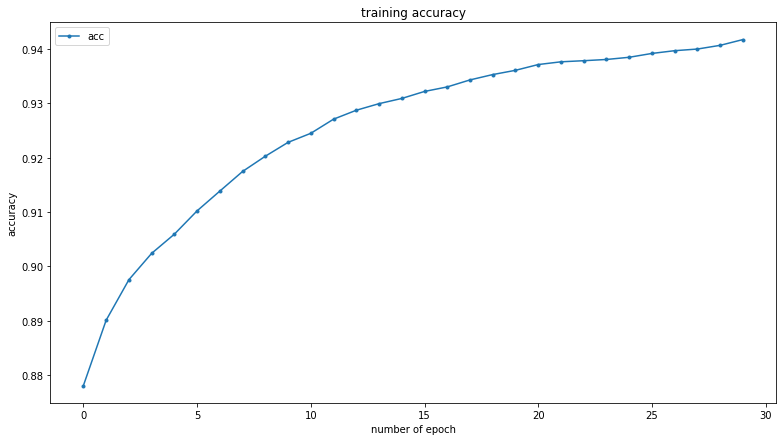

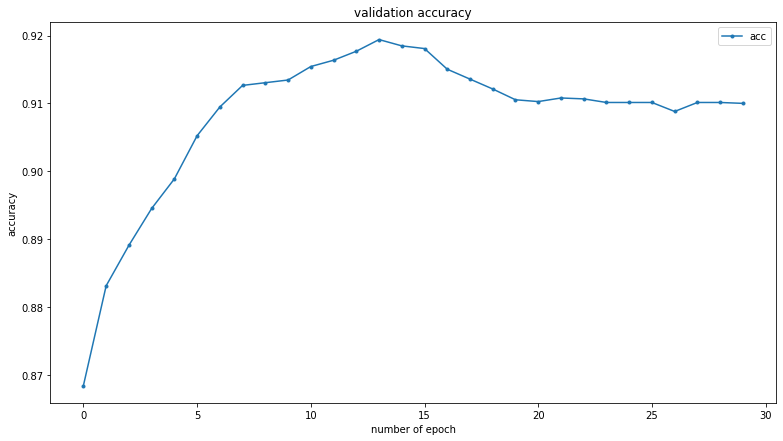

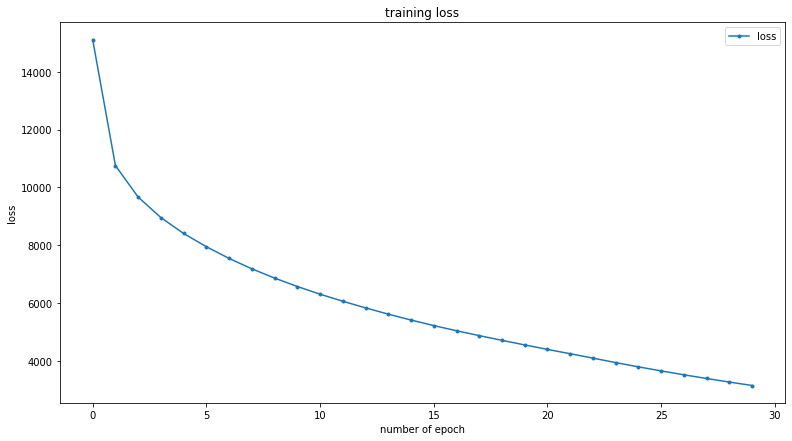

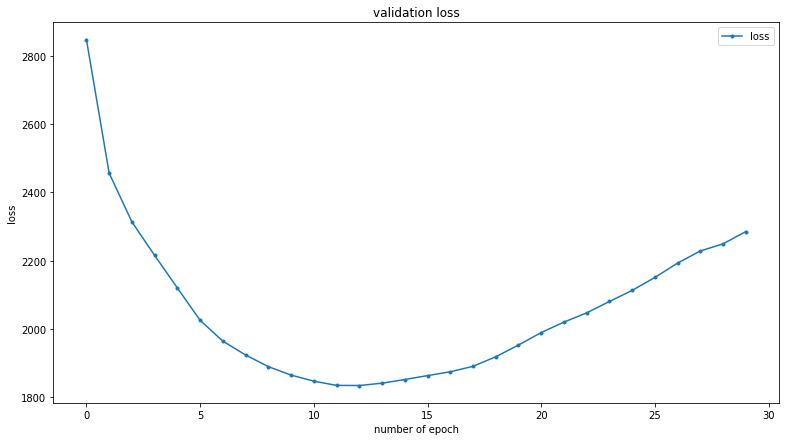

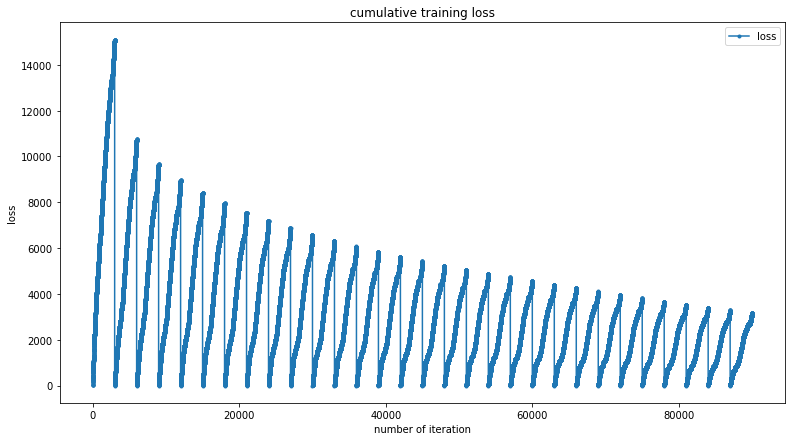

In [11]:
#### define the model########
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Setup input and output for the pytorch model########
input_key = 'input_word_vectors'

train_input_index =  df_train[input_key].values
val_input_index = df_val[input_key].values

train_output_index = df_train['output_index'].values
val_output_index = df_val['output_index'].values

# there's no test output but we created a dummy output for accuracy function reuse purpose
test_input_index = df_test[input_key].values
test_output_index_dummy = [len(test_input_index[i])*[0] for i in range(len(test_input_index))]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_DIM = len(df_train[input_key].values[0][0])


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, 'None',num_lstm=1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

#use the training function to train the model
model, log_e_train_acc, log_e_val_acc, log_e_train_loss,log_e_val_loss, log_i_train_loss = train(model,epochs,train_input_index,val_input_index,train_output_index,val_output_index )
plot(log_e_train_acc, log_e_val_acc, log_e_train_loss, log_e_val_loss, log_i_train_loss)

### Validation score and Count the labels

In [12]:
y_true,y_pred,_ = cal_acc(model,val_input_index,val_output_index)

def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_ix.items()}
    return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_true_decode,y_pred_decode,digits=4))

# prediction
df_prediction = pd.DataFrame()
df_prediction['ID'] = [i for i in range(len(y_pred_decode))]
df_prediction['Predicted'] = y_pred_decode
print('prediction:')
print(df_prediction.groupby('Predicted').size().reset_index(name='counts'))
print('====================')
# true
print('true:')
df_true = pd.DataFrame()
df_true['ID'] = [i for i in range(len(y_true_decode))]
df_true['Predicted'] = y_true_decode
print(df_true.groupby('Predicted').size().reset_index(name='counts'))

              precision    recall  f1-score   support

       I-LOC     0.7091    0.8902    0.7894       419
      I-MISC     0.5366    0.3529    0.4258       187
       I-ORG     0.6313    0.3965    0.4871       285
       I-PER     0.9262    0.7749    0.8438       875
           O     0.9416    0.9751    0.9581      5790

    accuracy                         0.9100      7556
   macro avg     0.7490    0.6779    0.7008      7556
weighted avg     0.9052    0.9100    0.9046      7556

prediction:
  Predicted  counts
0     I-LOC     526
1    I-MISC     123
2     I-ORG     179
3     I-PER     732
4         O    5996
true:
  Predicted  counts
0     I-LOC     419
1    I-MISC     187
2     I-ORG     285
3     I-PER     875
4         O    5790


### Save and load the model

In [13]:
torch.save(model, 'model_1.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BiLSTM_CRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Model_2 - Baseline Model + POS tagging embeddings

use attention: None
use number of lstm layer: 1
start training
input embeddings type: input_word_POS
input embeddings size: 26
Epoch:1, Training loss: 15266.34, train acc: 0.8817, val loss: 2798.12, val acc: 0.8763, time: 122.48s
Epoch:2, Training loss: 10711.77, train acc: 0.8923, val loss: 2449.77, val acc: 0.8857, time: 122.18s
Epoch:3, Training loss: 9602.78, train acc: 0.8987, val loss: 2269.64, val acc: 0.8920, time: 121.87s
Epoch:4, Training loss: 8853.04, train acc: 0.9041, val loss: 2161.92, val acc: 0.8958, time: 121.53s
Epoch:5, Training loss: 8266.93, train acc: 0.9082, val loss: 2069.00, val acc: 0.9034, time: 121.11s
Epoch:6, Training loss: 7792.84, train acc: 0.9124, val loss: 1980.38, val acc: 0.9068, time: 121.73s
Epoch:7, Training loss: 7399.15, train acc: 0.9163, val loss: 1904.29, val acc: 0.9096, time: 121.38s
Epoch:8, Training loss: 7052.49, train acc: 0.9200, val loss: 1844.97, val acc: 0.9132, time: 122.35s
Epoch:9, Training loss: 6735.51, train acc: 0.9230, val

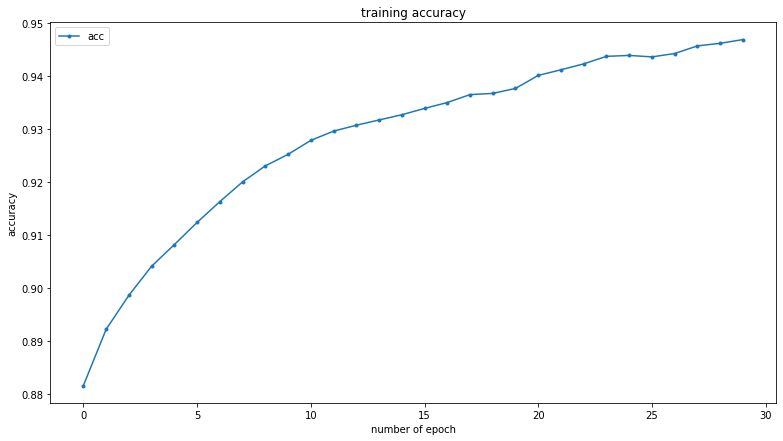

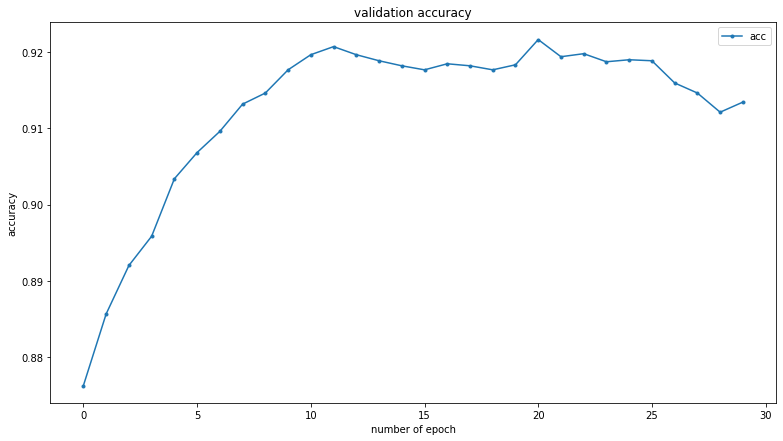

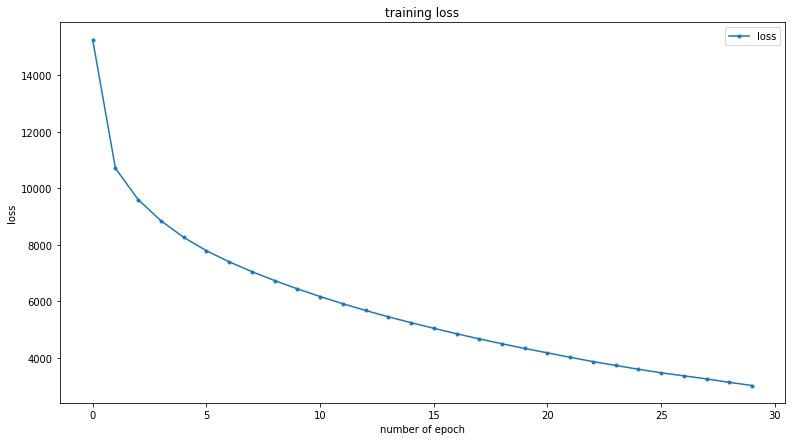

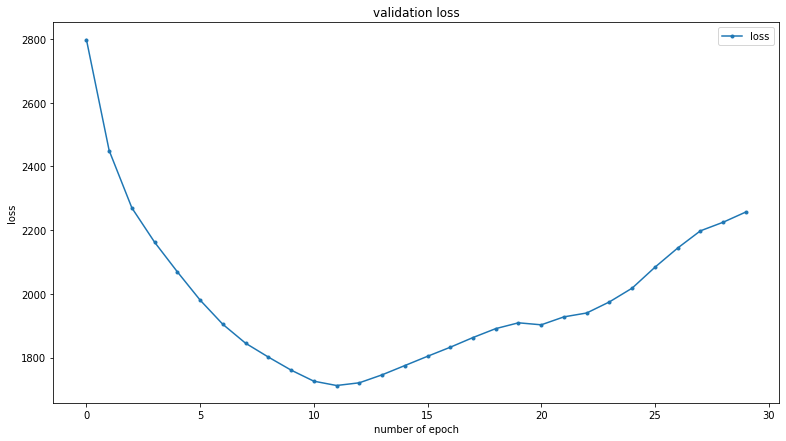

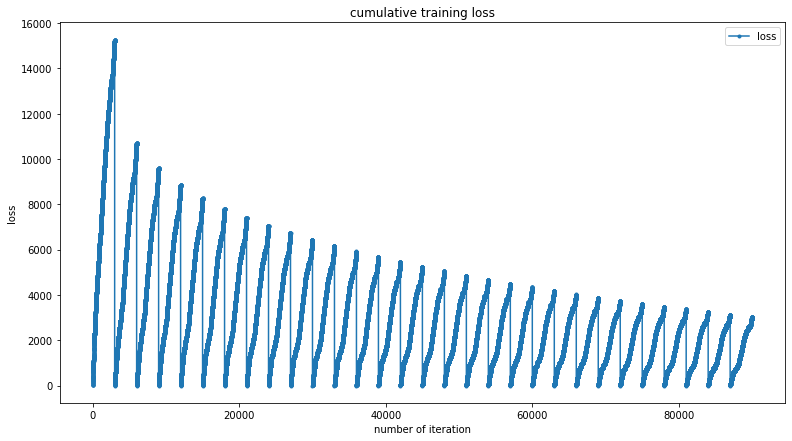

In [14]:
#### define the model########
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#### Setup input and output for the pytorch model########
input_key = 'input_word_POS'

train_input_index =  df_train[input_key].values
val_input_index = df_val[input_key].values

train_output_index = df_train['output_index'].values
val_output_index = df_val['output_index'].values

# there's no test output but we created a dummy output for accuracy function reuse purpose
test_input_index = df_test[input_key].values
test_output_index_dummy = [ len(test_input_index[i])*[0] for i in range(len(test_input_index))]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_DIM = len(df_train[input_key].values[0][0])


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, 'None',num_lstm=1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

#use the training function to train the model
model, log_e_train_acc, log_e_val_acc, log_e_train_loss,log_e_val_loss, log_i_train_loss = train(model,epochs,train_input_index,val_input_index,train_output_index,val_output_index )
plot(log_e_train_acc, log_e_val_acc, log_e_train_loss, log_e_val_loss, log_i_train_loss)

### Validation score and Count the labels

In [15]:
y_true,y_pred,_ = cal_acc(model,val_input_index,val_output_index)

def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_ix.items()}
    return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_true_decode,y_pred_decode,digits=4))

# prediction
df_prediction = pd.DataFrame()
df_prediction['ID'] = [i for i in range(len(y_pred_decode))]
df_prediction['Predicted'] = y_pred_decode
print('prediction:')
print(df_prediction.groupby('Predicted').size().reset_index(name='counts'))
print('====================')
# true
print('true:')
df_true = pd.DataFrame()
df_true['ID'] = [i for i in range(len(y_true_decode))]
df_true['Predicted'] = y_true_decode
print(df_true.groupby('Predicted').size().reset_index(name='counts'))

              precision    recall  f1-score   support

       I-LOC     0.7282    0.8759    0.7952       419
      I-MISC     0.6610    0.4171    0.5115       187
       I-ORG     0.5585    0.5193    0.5382       285
       I-PER     0.9499    0.7589    0.8437       875
           O     0.9456    0.9750    0.9600      5790

    accuracy                         0.9134      7556
   macro avg     0.7686    0.7092    0.7297      7556
weighted avg     0.9124    0.9134    0.9104      7556

prediction:
  Predicted  counts
0     I-LOC     504
1    I-MISC     118
2     I-ORG     265
3     I-PER     699
4         O    5970
true:
  Predicted  counts
0     I-LOC     419
1    I-MISC     187
2     I-ORG     285
3     I-PER     875
4         O    5790


### Save and load the model

In [16]:
torch.save(model, 'model_2.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BiLSTM_CRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Model_3 - Baseline Model + dependency parsing

use attention: None
use number of lstm layer: 1
start training
input embeddings type: input_word_par
input embeddings size: 26
Epoch:1, Training loss: 14765.89, train acc: 0.8860, val loss: 2722.76, val acc: 0.8806, time: 119.79s
Epoch:2, Training loss: 10496.58, train acc: 0.8945, val loss: 2398.15, val acc: 0.8890, time: 118.70s
Epoch:3, Training loss: 9454.60, train acc: 0.9012, val loss: 2244.81, val acc: 0.8954, time: 118.94s
Epoch:4, Training loss: 8800.50, train acc: 0.9052, val loss: 2145.82, val acc: 0.8974, time: 120.58s
Epoch:5, Training loss: 8301.19, train acc: 0.9086, val loss: 2090.08, val acc: 0.9002, time: 119.09s
Epoch:6, Training loss: 7890.29, train acc: 0.9109, val loss: 2062.36, val acc: 0.9014, time: 121.84s
Epoch:7, Training loss: 7529.67, train acc: 0.9116, val loss: 2059.27, val acc: 0.9018, time: 119.81s
Epoch:8, Training loss: 7198.24, train acc: 0.9129, val loss: 2053.16, val acc: 0.9021, time: 120.54s
Epoch:9, Training loss: 6903.68, train acc: 0.9147, val

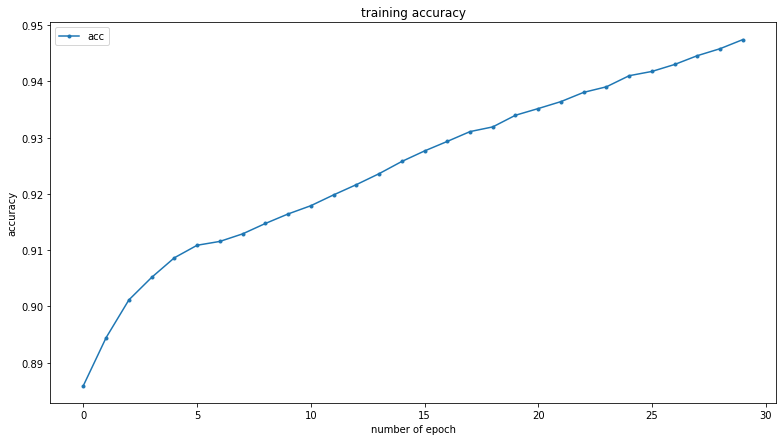

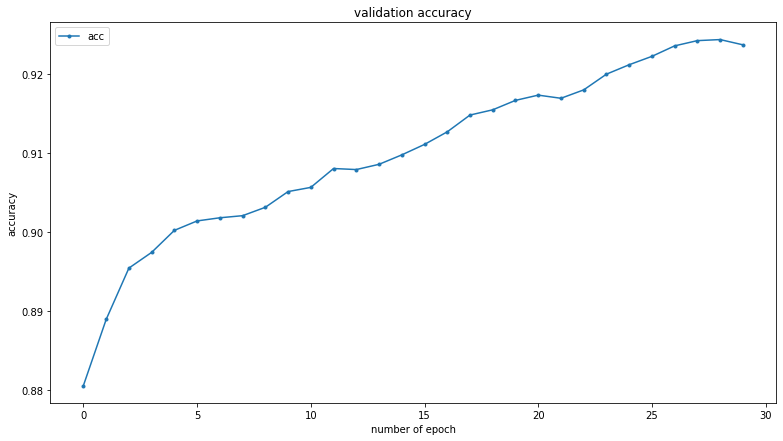

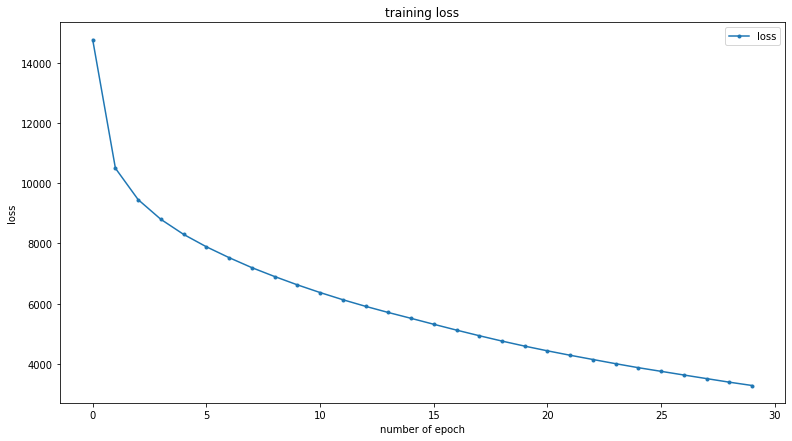

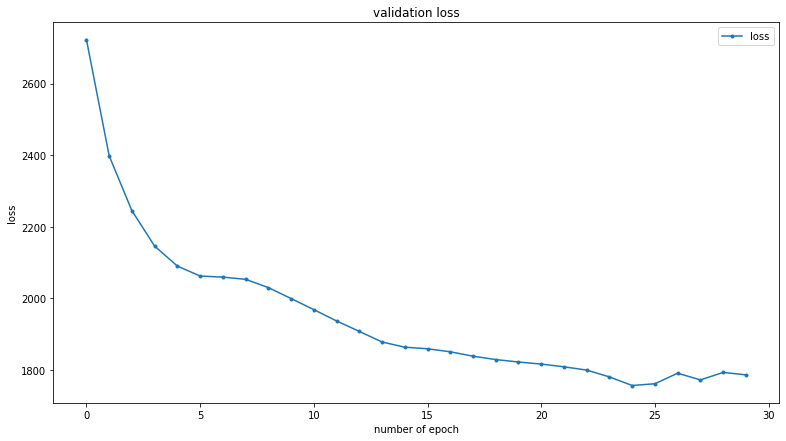

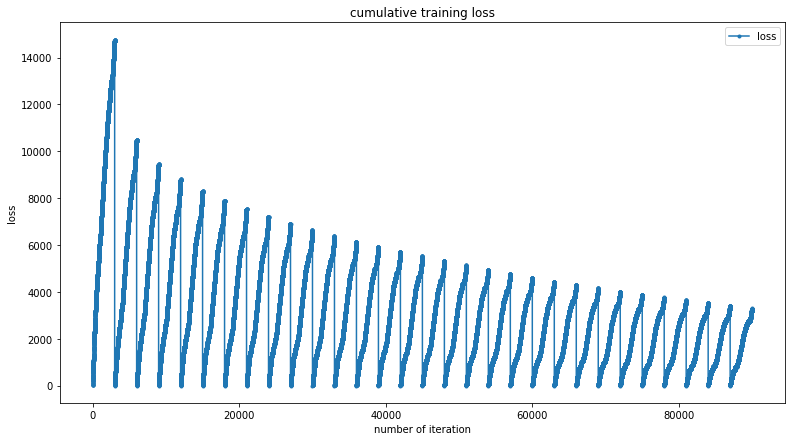

In [17]:
#### define the model########
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#### Setup input and output for the pytorch model########
input_key = 'input_word_par'

train_input_index =  df_train[input_key].values
val_input_index = df_val[input_key].values

train_output_index = df_train['output_index'].values
val_output_index = df_val['output_index'].values

# there's no test output but we created a dummy output for accuracy function reuse purpose
test_input_index = df_test[input_key].values
test_output_index_dummy = [ len(test_input_index[i])*[0] for i in range(len(test_input_index))]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_DIM = len(df_train[input_key].values[0][0])


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, 'None',num_lstm=1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

#use the training function to train the model
model, log_e_train_acc, log_e_val_acc, log_e_train_loss,log_e_val_loss, log_i_train_loss = train(model,epochs,train_input_index,val_input_index,train_output_index,val_output_index )
plot(log_e_train_acc, log_e_val_acc, log_e_train_loss, log_e_val_loss, log_i_train_loss)

### Validation score and Count the labels

In [18]:
y_true,y_pred,_ = cal_acc(model,val_input_index,val_output_index)

def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_ix.items()}
    return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_true_decode,y_pred_decode,digits=4))

# prediction
df_prediction = pd.DataFrame()
df_prediction['ID'] = [i for i in range(len(y_pred_decode))]
df_prediction['Predicted'] = y_pred_decode
print('prediction:')
print(df_prediction.groupby('Predicted').size().reset_index(name='counts'))
print('====================')
# true
print('true:')
df_true = pd.DataFrame()
df_true['ID'] = [i for i in range(len(y_true_decode))]
df_true['Predicted'] = y_true_decode
print(df_true.groupby('Predicted').size().reset_index(name='counts'))

              precision    recall  f1-score   support

       I-LOC     0.8004    0.9093    0.8514       419
      I-MISC     0.5342    0.4171    0.4685       187
       I-ORG     0.7181    0.4737    0.5708       285
       I-PER     0.9338    0.8377    0.8831       875
           O     0.9482    0.9762    0.9620      5790

    accuracy                         0.9236      7556
   macro avg     0.7869    0.7228    0.7472      7556
weighted avg     0.9194    0.9236    0.9197      7556

prediction:
  Predicted  counts
0     I-LOC     476
1    I-MISC     146
2     I-ORG     188
3     I-PER     785
4         O    5961
true:
  Predicted  counts
0     I-LOC     419
1    I-MISC     187
2     I-ORG     285
3     I-PER     875
4         O    5790


### Save and load the model

In [19]:
torch.save(model, 'model_3.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BiLSTM_CRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Model_4 - Baseline Model + POS Tagging + dependency parsing - All embeddings

use attention: None
use number of lstm layer: 1
start training
input embeddings type: input_word_POS_par
input embeddings size: 27
Epoch:1, Training loss: 19083.46, train acc: 0.8409, val loss: 4068.10, val acc: 0.8113, time: 104.84s
Epoch:2, Training loss: 15278.01, train acc: 0.8538, val loss: 3649.76, val acc: 0.8393, time: 104.31s
Epoch:3, Training loss: 14610.34, train acc: 0.8604, val loss: 3432.33, val acc: 0.8462, time: 104.16s
Epoch:4, Training loss: 13955.96, train acc: 0.8603, val loss: 3264.29, val acc: 0.8432, time: 104.92s
Epoch:5, Training loss: 13207.50, train acc: 0.8729, val loss: 2840.10, val acc: 0.8698, time: 104.41s
Epoch:6, Training loss: 12965.35, train acc: 0.8716, val loss: 2914.71, val acc: 0.8661, time: 104.12s
Epoch:7, Training loss: 12419.87, train acc: 0.8754, val loss: 2856.45, val acc: 0.8643, time: 104.64s
Epoch:8, Training loss: 12195.38, train acc: 0.8771, val loss: 2759.28, val acc: 0.8715, time: 104.35s
Epoch:9, Training loss: 11594.09, train acc: 

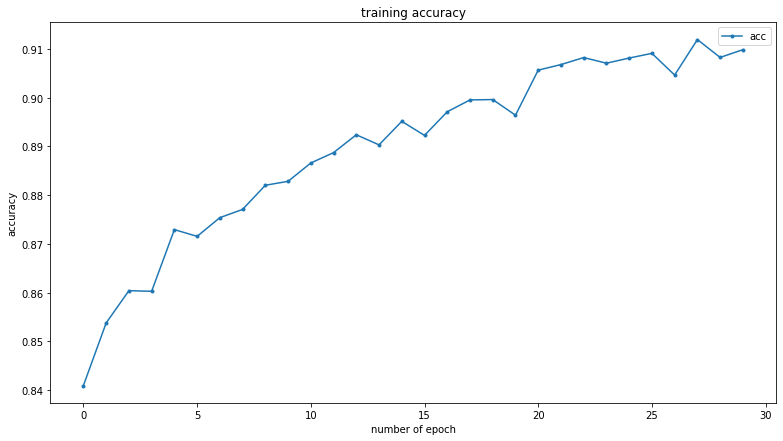

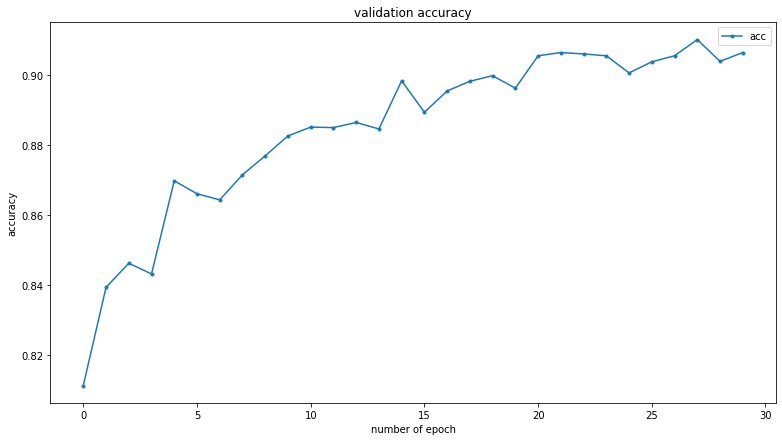

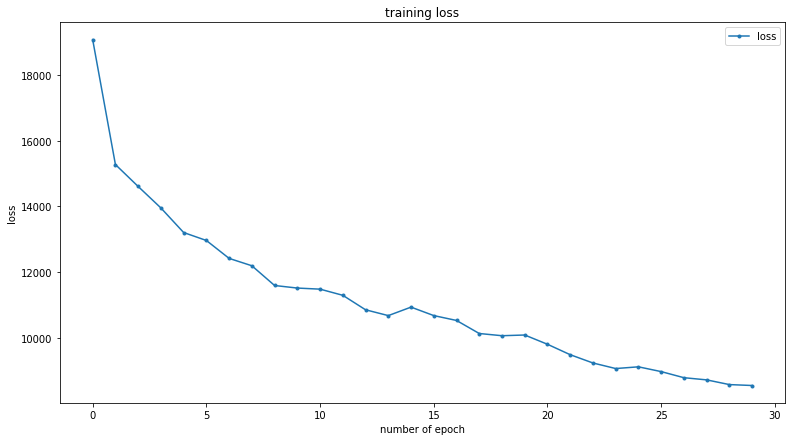

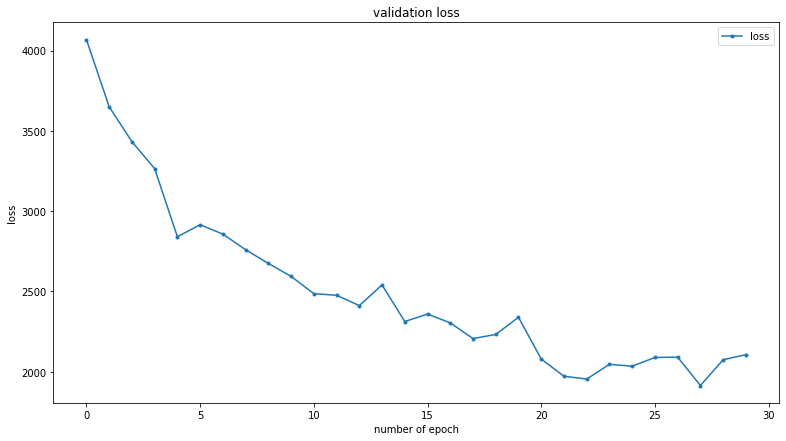

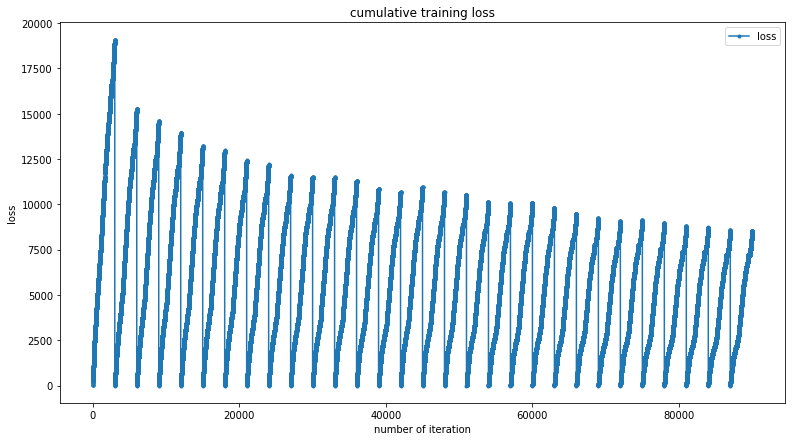

In [0]:
#### define the model########
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#### Setup input and output for the pytorch model########
input_key = 'input_word_POS_par'

train_input_index =  df_train[input_key].values
val_input_index = df_val[input_key].values

train_output_index = df_train['output_index'].values
val_output_index = df_val['output_index'].values

# there's no test output but we created a dummy output for accuracy function reuse purpose
test_input_index = df_test[input_key].values
test_output_index_dummy = [ len(test_input_index[i])*[0] for i in range(len(test_input_index))]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_DIM = len(df_train[input_key].values[0][0])


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, 'None',num_lstm=1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

#use the training function to train the model
model, log_e_train_acc, log_e_val_acc, log_e_train_loss,log_e_val_loss, log_i_train_loss = train(model,epochs,train_input_index,val_input_index,train_output_index,val_output_index )
plot(log_e_train_acc, log_e_val_acc, log_e_train_loss, log_e_val_loss, log_i_train_loss)

### Validation score and Count the labels

In [0]:
y_true,y_pred,_ = cal_acc(model,val_input_index,val_output_index)

def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_ix.items()}
    return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_true_decode,y_pred_decode,digits=4))

# prediction
df_prediction = pd.DataFrame()
df_prediction['ID'] = [i for i in range(len(y_pred_decode))]
df_prediction['Predicted'] = y_pred_decode
print('prediction:')
print(df_prediction.groupby('Predicted').size().reset_index(name='counts'))
print('====================')
# true
print('true:')
df_true = pd.DataFrame()
df_true['ID'] = [i for i in range(len(y_true_decode))]
df_true['Predicted'] = y_true_decode
print(df_true.groupby('Predicted').size().reset_index(name='counts'))

              precision    recall  f1-score   support

       I-LOC     0.7444    0.7995    0.7710       419
      I-MISC     0.7215    0.3048    0.4286       187
       I-ORG     0.7931    0.4035    0.5349       285
       I-PER     0.8902    0.7509    0.8146       875
           O     0.9253    0.9819    0.9527      5790

    accuracy                         0.9064      7556
   macro avg     0.8149    0.6481    0.7004      7556
weighted avg     0.9012    0.9064    0.8979      7556

prediction:
  Predicted  counts
0     I-LOC     450
1    I-MISC      79
2     I-ORG     145
3     I-PER     738
4         O    6144
true:
  Predicted  counts
0     I-LOC     419
1    I-MISC     187
2     I-ORG     285
3     I-PER     875
4         O    5790


### Save and load the model

In [0]:
torch.save(model, 'model_4.pt')

### Model_5 - Baseline Model + attention dot product

use attention: Dot_Product
use number of lstm layer: 1
start training
input embeddings type: input_word_vectors
input embeddings size: 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:111: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:1, Training loss: 14828.56, train acc: 0.8818, val loss: 2805.74, val acc: 0.8724, time: 112.25s
Epoch:2, Training loss: 10508.18, train acc: 0.8925, val loss: 2445.07, val acc: 0.8850, time: 113.70s
Epoch:3, Training loss: 9459.11, train acc: 0.8973, val loss: 2328.60, val acc: 0.8870, time: 112.93s
Epoch:4, Training loss: 8783.79, train acc: 0.9021, val loss: 2255.88, val acc: 0.8903, time: 113.57s
Epoch:5, Training loss: 8222.57, train acc: 0.9066, val loss: 2172.30, val acc: 0.8935, time: 115.14s
Epoch:6, Training loss: 7730.44, train acc: 0.9110, val loss: 2099.83, val acc: 0.8957, time: 114.44s
Epoch:7, Training loss: 7309.22, train acc: 0.9149, val loss: 2041.31, val acc: 0.8990, time: 113.56s
Epoch:8, Training loss: 6937.50, train acc: 0.9190, val loss: 1993.18, val acc: 0.9029, time: 114.83s
Epoch:9, Training loss: 6593.08, train acc: 0.9214, val loss: 1969.33, val acc: 0.9070, time: 114.29s
Epoch:10, Training loss: 6272.46, train acc: 0.9227, val loss: 1978.37, val acc:

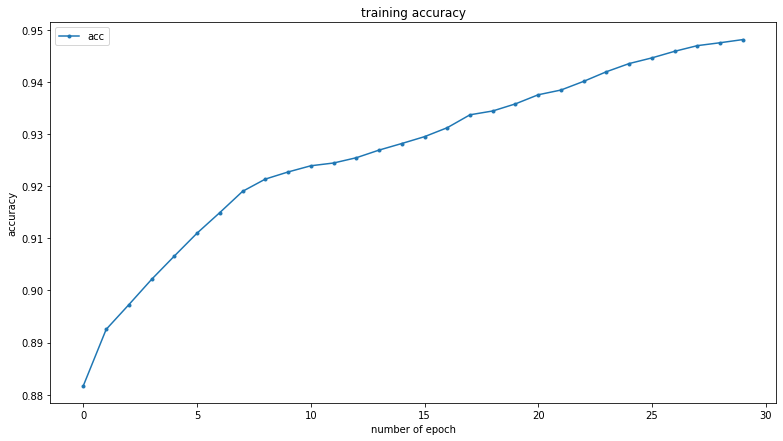

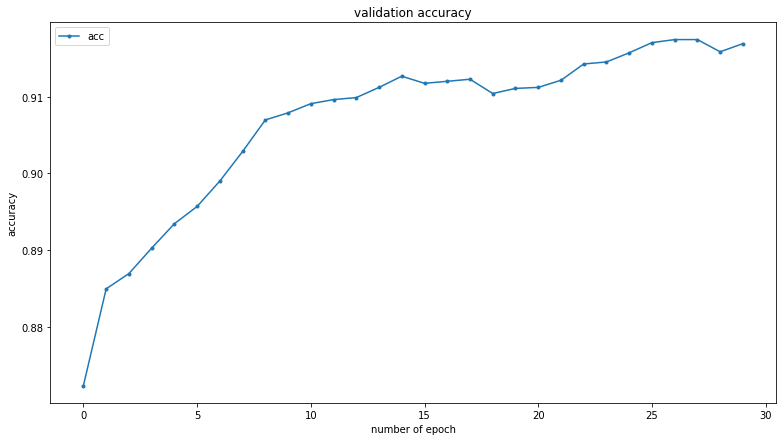

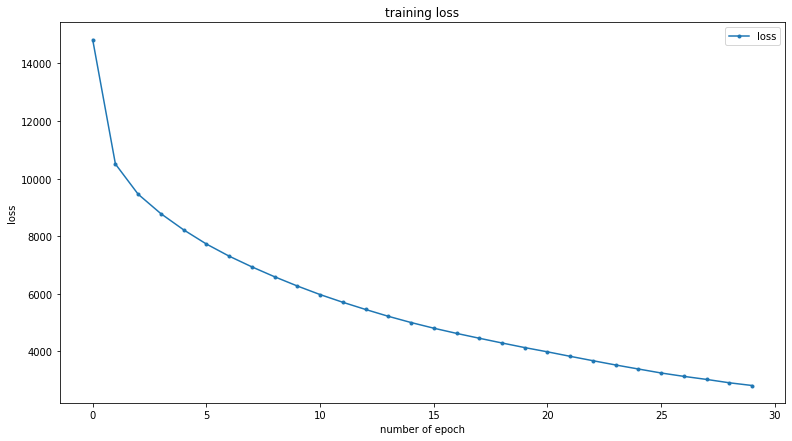

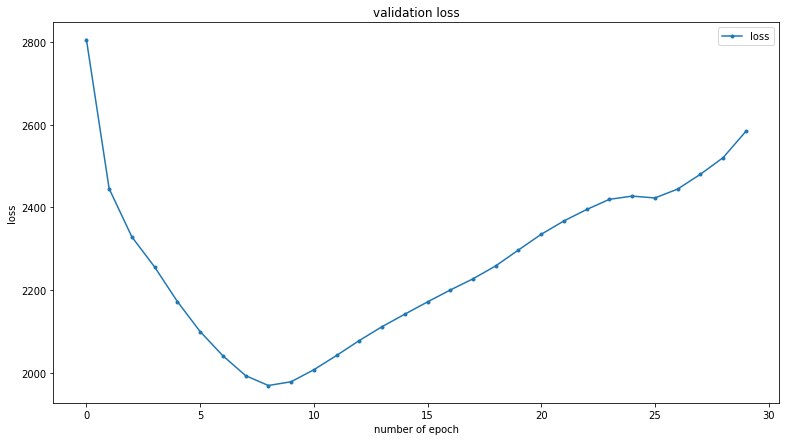

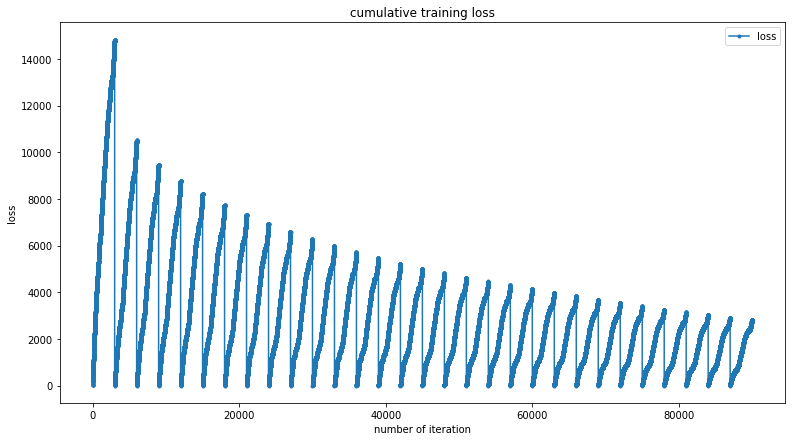

In [0]:
#### define the model########
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#### Setup input and output for the pytorch model########
input_key = 'input_word_vectors'

train_input_index =  df_train[input_key].values
val_input_index = df_val[input_key].values

train_output_index = df_train['output_index'].values
val_output_index = df_val['output_index'].values

# there's no test output but we created a dummy output for accuracy function reuse purpose
test_input_index = df_test[input_key].values
test_output_index_dummy = [ len(test_input_index[i])*[0] for i in range(len(test_input_index))]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_DIM = len(df_train[input_key].values[0][0])


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, 'Dot_Product',num_lstm=1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

#use the training function to train the model
model, log_e_train_acc, log_e_val_acc, log_e_train_loss,log_e_val_loss, log_i_train_loss = train(model,epochs,train_input_index,val_input_index,train_output_index,val_output_index )
plot(log_e_train_acc, log_e_val_acc, log_e_train_loss, log_e_val_loss, log_i_train_loss)

### Validation score and Count the labels

In [0]:
y_true,y_pred,_ = cal_acc(model,val_input_index,val_output_index)

def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_ix.items()}
    return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_true_decode,y_pred_decode,digits=4))

# prediction
df_prediction = pd.DataFrame()
df_prediction['ID'] = [i for i in range(len(y_pred_decode))]
df_prediction['Predicted'] = y_pred_decode
print('prediction:')
print(df_prediction.groupby('Predicted').size().reset_index(name='counts'))
print('====================')
# true
print('true:')
df_true = pd.DataFrame()
df_true['ID'] = [i for i in range(len(y_true_decode))]
df_true['Predicted'] = y_true_decode
print(df_true.groupby('Predicted').size().reset_index(name='counts'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:111: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


              precision    recall  f1-score   support

       I-LOC     0.6853    0.9093    0.7815       419
      I-MISC     0.5041    0.3316    0.4000       187
       I-ORG     0.7153    0.3614    0.4802       285
       I-PER     0.9450    0.8046    0.8691       875
           O     0.9482    0.9807    0.9642      5790

    accuracy                         0.9169      7556
   macro avg     0.7596    0.6775    0.6990      7556
weighted avg     0.9135    0.9169    0.9108      7556

prediction:
  Predicted  counts
0     I-LOC     556
1    I-MISC     123
2     I-ORG     144
3     I-PER     745
4         O    5988
true:
  Predicted  counts
0     I-LOC     419
1    I-MISC     187
2     I-ORG     285
3     I-PER     875
4         O    5790


### Save and load the model

In [0]:
torch.save(model, 'model_5.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BiLSTM_CRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Model_6 - Baseline Model + attention Scaled dot product

use attention: Scaled_Dot_Product
use number of lstm layer: 1
start training
input embeddings type: input_word_vectors
input embeddings size: 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:1, Training loss: 15011.43, train acc: 0.8829, val loss: 2892.62, val acc: 0.8732, time: 122.46s
Epoch:2, Training loss: 10383.75, train acc: 0.8918, val loss: 2523.77, val acc: 0.8821, time: 122.94s
Epoch:3, Training loss: 9326.79, train acc: 0.8964, val loss: 2388.44, val acc: 0.8857, time: 121.84s
Epoch:4, Training loss: 8646.84, train acc: 0.9007, val loss: 2290.95, val acc: 0.8890, time: 121.87s
Epoch:5, Training loss: 8097.10, train acc: 0.9054, val loss: 2209.12, val acc: 0.8929, time: 122.78s
Epoch:6, Training loss: 7625.95, train acc: 0.9104, val loss: 2146.46, val acc: 0.8992, time: 122.36s
Epoch:7, Training loss: 7214.97, train acc: 0.9136, val loss: 2109.36, val acc: 0.9011, time: 123.10s
Epoch:8, Training loss: 6852.35, train acc: 0.9167, val loss: 2093.50, val acc: 0.9033, time: 121.32s
Epoch:9, Training loss: 6526.54, train acc: 0.9194, val loss: 2082.56, val acc: 0.9022, time: 122.16s
Epoch:10, Training loss: 6224.41, train acc: 0.9213, val loss: 2072.85, val acc:

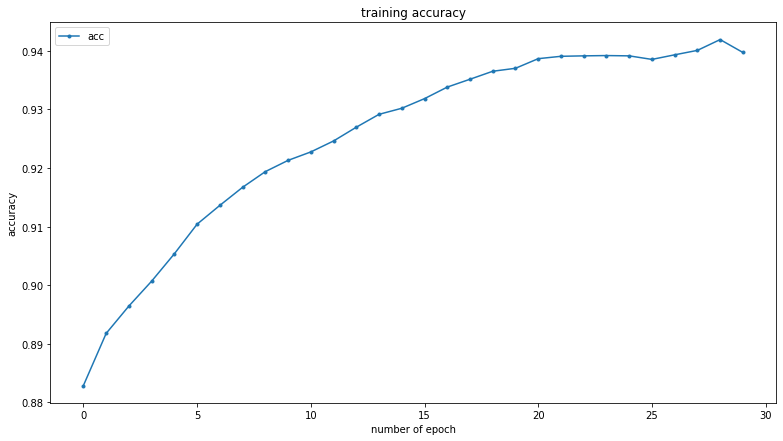

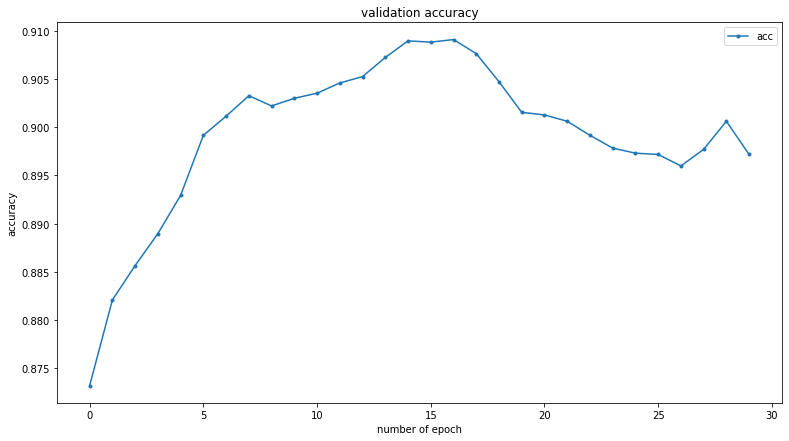

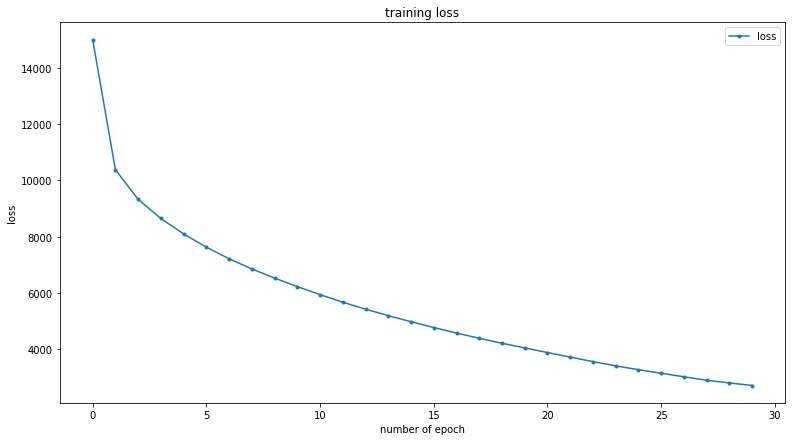

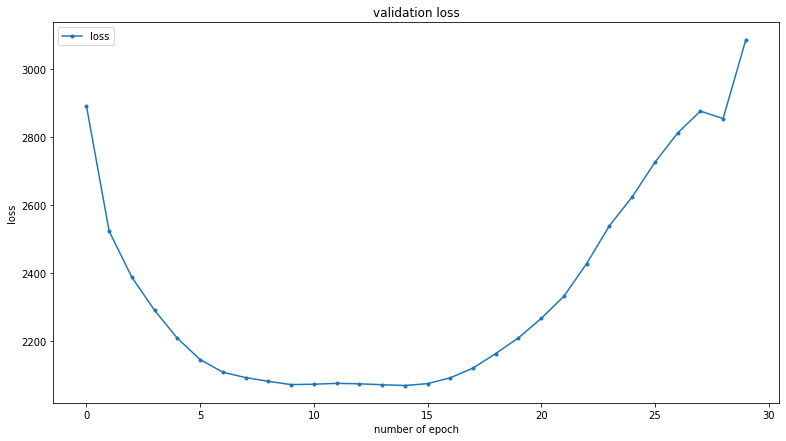

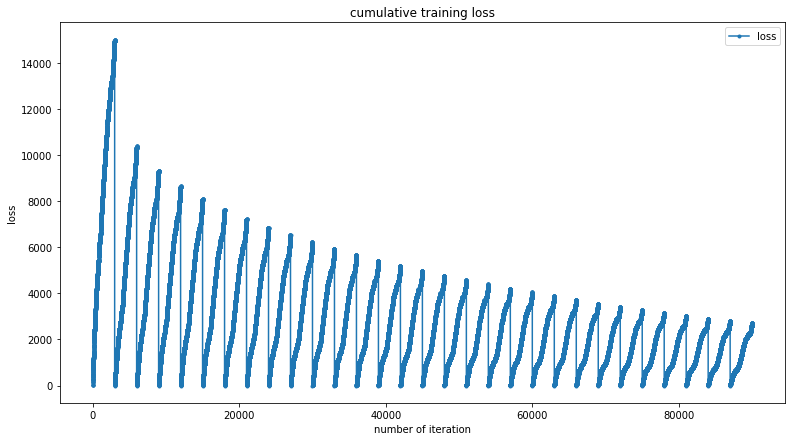

In [0]:
#### define the model########
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#### Setup input and output for the pytorch model########
input_key = 'input_word_vectors'

train_input_index =  df_train[input_key].values
val_input_index = df_val[input_key].values

train_output_index = df_train['output_index'].values
val_output_index = df_val['output_index'].values

# there's no test output but we created a dummy output for accuracy function reuse purpose
test_input_index = df_test[input_key].values
test_output_index_dummy = [ len(test_input_index[i])*[0] for i in range(len(test_input_index))]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_DIM = len(df_train[input_key].values[0][0])


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, 'Scaled_Dot_Product',num_lstm=1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

#use the training function to train the model
model, log_e_train_acc, log_e_val_acc, log_e_train_loss,log_e_val_loss, log_i_train_loss = train(model,epochs,train_input_index,val_input_index,train_output_index,val_output_index )
plot(log_e_train_acc, log_e_val_acc, log_e_train_loss, log_e_val_loss, log_i_train_loss)

### Validation score and Count the labels

In [0]:
y_true,y_pred,_ = cal_acc(model,val_input_index,val_output_index)

def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_ix.items()}
    return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_true_decode,y_pred_decode,digits=4))

# prediction
df_prediction = pd.DataFrame()
df_prediction['ID'] = [i for i in range(len(y_pred_decode))]
df_prediction['Predicted'] = y_pred_decode
print('prediction:')
print(df_prediction.groupby('Predicted').size().reset_index(name='counts'))
print('====================')
# true
print('true:')
df_true = pd.DataFrame()
df_true['ID'] = [i for i in range(len(y_true_decode))]
df_true['Predicted'] = y_true_decode
print(df_true.groupby('Predicted').size().reset_index(name='counts'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


              precision    recall  f1-score   support

       I-LOC     0.7359    0.9045    0.8116       419
      I-MISC     0.4022    0.1979    0.2652       187
       I-ORG     0.4298    0.3649    0.3947       285
       I-PER     0.9398    0.6606    0.7758       875
           O     0.9325    0.9812    0.9562      5790

    accuracy                         0.8972      7556
   macro avg     0.6880    0.6218    0.6407      7556
weighted avg     0.8904    0.8972    0.8890      7556

prediction:
  Predicted  counts
0     I-LOC     515
1    I-MISC      92
2     I-ORG     242
3     I-PER     615
4         O    6092
true:
  Predicted  counts
0     I-LOC     419
1    I-MISC     187
2     I-ORG     285
3     I-PER     875
4         O    5790


### Save and load the model

In [0]:
torch.save(model, 'model_6.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BiLSTM_CRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Model_7 - Baseline Model + 2 layers bi-LSTM

use attention: None
use number of lstm layer: 2
start training
input embeddings type: input_word_vectors
input embeddings size: 25
Epoch:1, Training loss: 17503.44, train acc: 0.8733, val loss: 3188.06, val acc: 0.8600, time: 144.43s
Epoch:2, Training loss: 11382.43, train acc: 0.8876, val loss: 2590.81, val acc: 0.8821, time: 144.99s
Epoch:3, Training loss: 10000.33, train acc: 0.8948, val loss: 2314.39, val acc: 0.8911, time: 145.56s
Epoch:4, Training loss: 9119.52, train acc: 0.8998, val loss: 2221.75, val acc: 0.8925, time: 145.55s
Epoch:5, Training loss: 8449.32, train acc: 0.9040, val loss: 2134.96, val acc: 0.8972, time: 147.00s
Epoch:6, Training loss: 7898.51, train acc: 0.9077, val loss: 2026.88, val acc: 0.9014, time: 147.92s
Epoch:7, Training loss: 7411.81, train acc: 0.9131, val loss: 1942.61, val acc: 0.9059, time: 146.05s
Epoch:8, Training loss: 6961.73, train acc: 0.9169, val loss: 1883.04, val acc: 0.9123, time: 145.90s
Epoch:9, Training loss: 6550.17, train acc: 0.9199

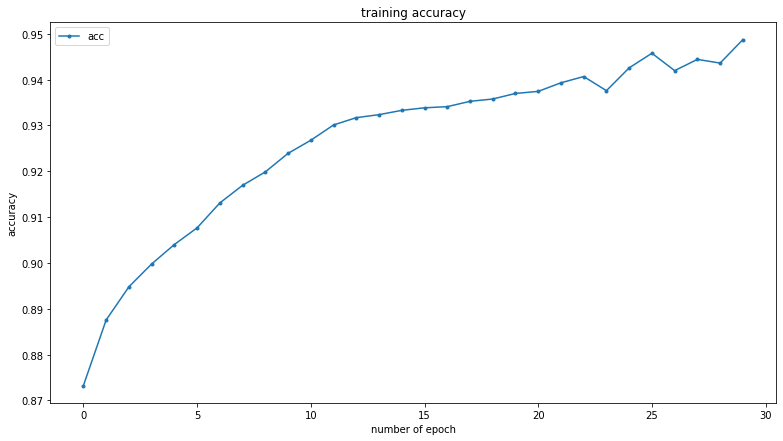

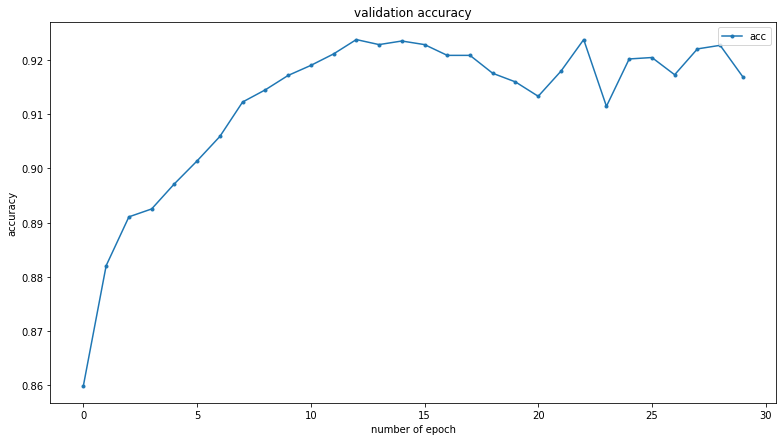

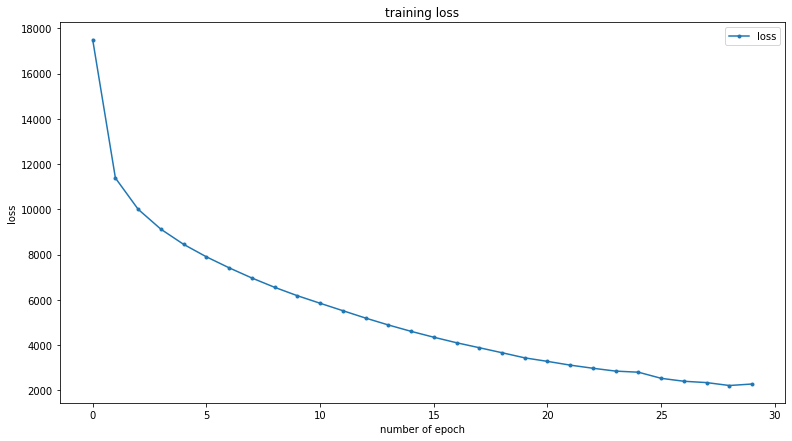

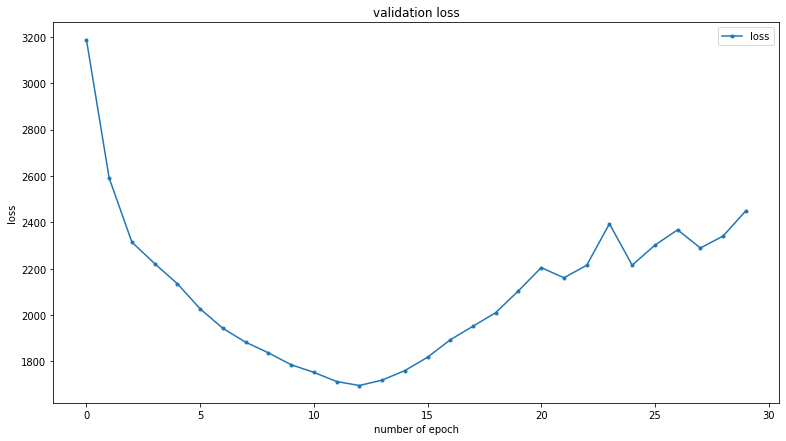

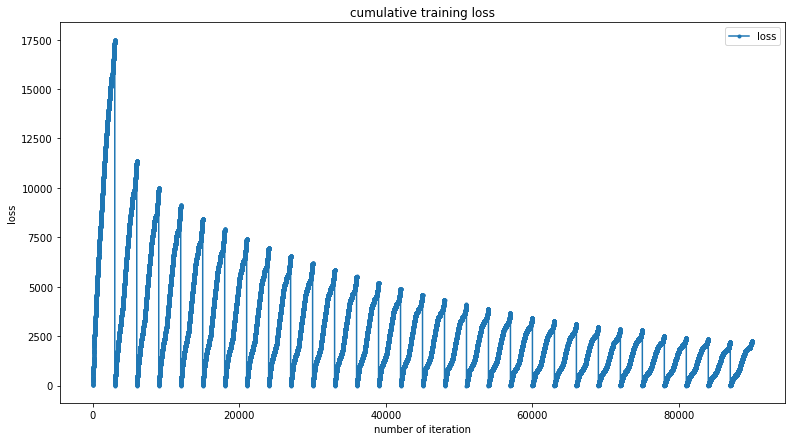

In [31]:
#### define the model########
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#### Setup input and output for the pytorch model########
input_key = 'input_word_vectors'

train_input_index =  df_train[input_key].values
val_input_index = df_val[input_key].values

train_output_index = df_train['output_index'].values
val_output_index = df_val['output_index'].values

# there's no test output but we created a dummy output for accuracy function reuse purpose
test_input_index = df_test[input_key].values
test_output_index_dummy = [ len(test_input_index[i])*[0] for i in range(len(test_input_index))]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_DIM = len(df_train[input_key].values[0][0])


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, 'None',num_lstm=2).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

#use the training function to train the model
model, log_e_train_acc, log_e_val_acc, log_e_train_loss,log_e_val_loss, log_i_train_loss = train(model,epochs,train_input_index,val_input_index,train_output_index,val_output_index )
plot(log_e_train_acc, log_e_val_acc, log_e_train_loss, log_e_val_loss, log_i_train_loss)

### Validation score and Count the labels

In [32]:
y_true,y_pred,_ = cal_acc(model,val_input_index,val_output_index)

def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_ix.items()}
    return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_true_decode,y_pred_decode,digits=4))

# prediction
df_prediction = pd.DataFrame()
df_prediction['ID'] = [i for i in range(len(y_pred_decode))]
df_prediction['Predicted'] = y_pred_decode
print('prediction:')
print(df_prediction.groupby('Predicted').size().reset_index(name='counts'))
print('====================')
# true
print('true:')
df_true = pd.DataFrame()
df_true['ID'] = [i for i in range(len(y_true_decode))]
df_true['Predicted'] = y_true_decode
print(df_true.groupby('Predicted').size().reset_index(name='counts'))

              precision    recall  f1-score   support

       I-LOC     0.7441    0.9021    0.8155       419
      I-MISC     0.5600    0.3743    0.4487       187
       I-ORG     0.6010    0.4070    0.4854       285
       I-PER     0.9484    0.7771    0.8543       875
           O     0.9453    0.9817    0.9631      5790

    accuracy                         0.9169      7556
   macro avg     0.7598    0.6885    0.7134      7556
weighted avg     0.9120    0.9169    0.9116      7556

prediction:
  Predicted  counts
0     I-LOC     508
1    I-MISC     125
2     I-ORG     193
3     I-PER     717
4         O    6013
true:
  Predicted  counts
0     I-LOC     419
1    I-MISC     187
2     I-ORG     285
3     I-PER     875
4         O    5790


### Save and load the model

In [33]:
torch.save(model, 'model_7.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BiLSTM_CRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Model_8 - Baseline Model + 3 layers bi-LSTM

use attention: None
use number of lstm layer: 3
start training
input embeddings type: input_word_vectors
input embeddings size: 25
Epoch:1, Training loss: 20908.53, train acc: 0.8432, val loss: 3701.85, val acc: 0.8205, time: 170.47s
Epoch:2, Training loss: 12843.44, train acc: 0.8834, val loss: 2676.27, val acc: 0.8806, time: 172.47s
Epoch:3, Training loss: 10500.76, train acc: 0.8932, val loss: 2419.64, val acc: 0.8894, time: 171.83s
Epoch:4, Training loss: 9540.70, train acc: 0.8976, val loss: 2315.78, val acc: 0.8945, time: 171.57s
Epoch:5, Training loss: 8877.21, train acc: 0.9010, val loss: 2256.65, val acc: 0.8974, time: 173.36s
Epoch:6, Training loss: 8385.88, train acc: 0.9062, val loss: 2199.87, val acc: 0.8996, time: 171.59s
Epoch:7, Training loss: 7944.43, train acc: 0.9085, val loss: 2154.98, val acc: 0.9025, time: 172.34s
Epoch:8, Training loss: 7519.58, train acc: 0.9111, val loss: 2082.43, val acc: 0.9054, time: 171.98s
Epoch:9, Training loss: 7105.29, train acc: 0.9143

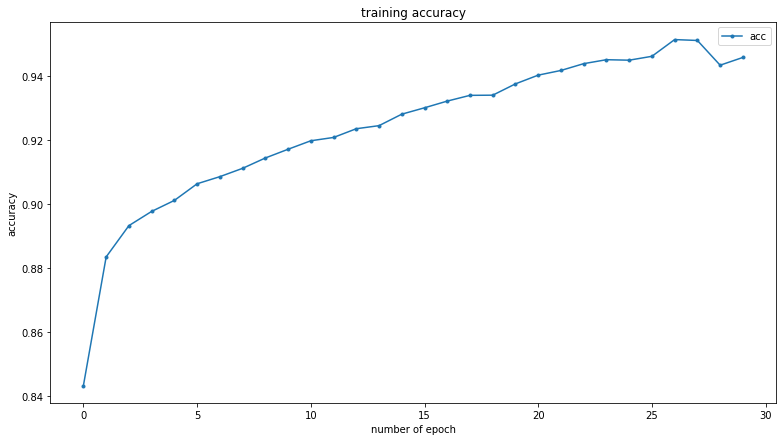

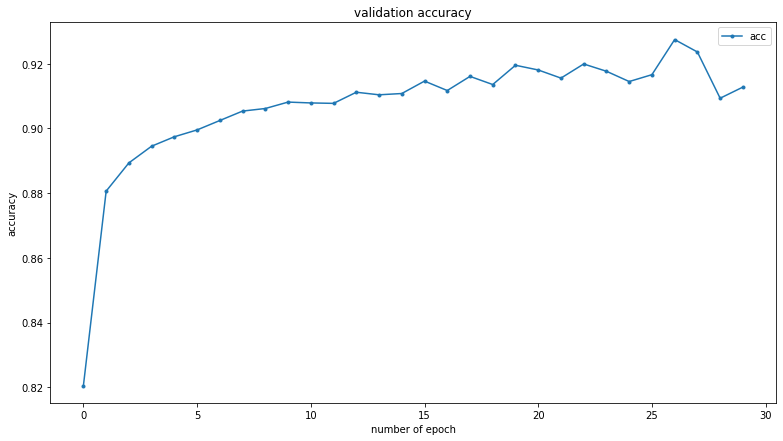

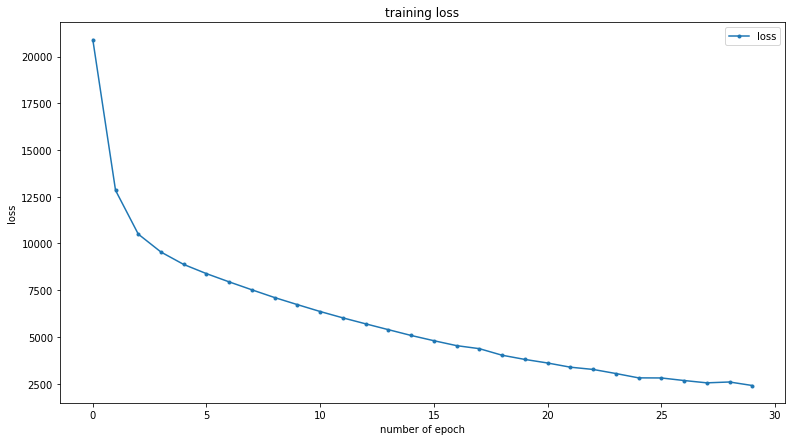

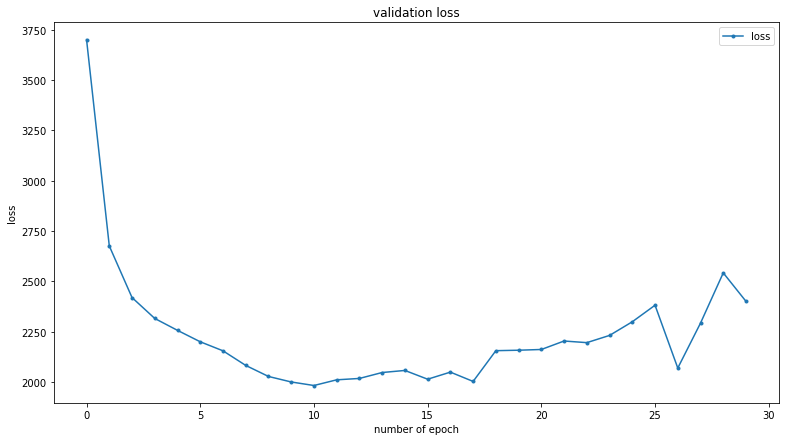

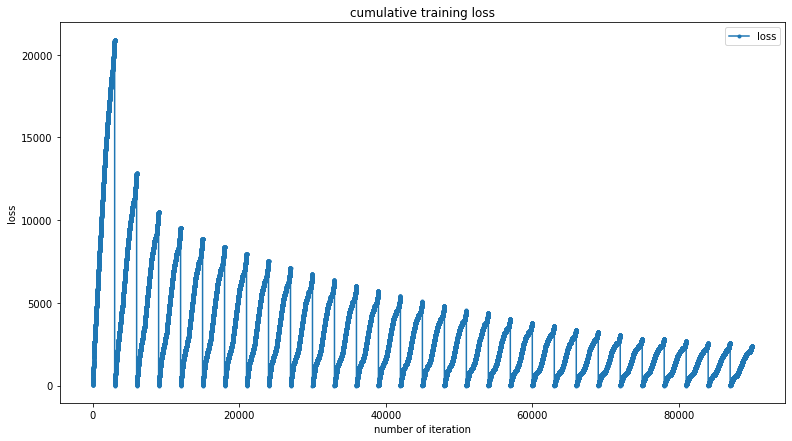

In [34]:
#### define the model########
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#### Setup input and output for the pytorch model########
input_key = 'input_word_vectors'

train_input_index =  df_train[input_key].values
val_input_index = df_val[input_key].values

train_output_index = df_train['output_index'].values
val_output_index = df_val['output_index'].values

# there's no test output but we created a dummy output for accuracy function reuse purpose
test_input_index = df_test[input_key].values
test_output_index_dummy = [ len(test_input_index[i])*[0] for i in range(len(test_input_index))]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_DIM = len(df_train[input_key].values[0][0])


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, 'None',num_lstm=3).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

#use the training function to train the model
model, log_e_train_acc, log_e_val_acc, log_e_train_loss,log_e_val_loss, log_i_train_loss = train(model,epochs,train_input_index,val_input_index,train_output_index,val_output_index )
plot(log_e_train_acc, log_e_val_acc, log_e_train_loss, log_e_val_loss, log_i_train_loss)

### Validation score and Count the labels

In [35]:
y_true,y_pred,_ = cal_acc(model,val_input_index,val_output_index)

def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_ix.items()}
    return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_true_decode,y_pred_decode,digits=4))

# prediction
df_prediction = pd.DataFrame()
df_prediction['ID'] = [i for i in range(len(y_pred_decode))]
df_prediction['Predicted'] = y_pred_decode
print('prediction:')
print(df_prediction.groupby('Predicted').size().reset_index(name='counts'))
print('====================')
# true
print('true:')
df_true = pd.DataFrame()
df_true['ID'] = [i for i in range(len(y_true_decode))]
df_true['Predicted'] = y_true_decode
print(df_true.groupby('Predicted').size().reset_index(name='counts'))

              precision    recall  f1-score   support

       I-LOC     0.7060    0.8998    0.7912       419
      I-MISC     0.5350    0.4492    0.4884       187
       I-ORG     0.5988    0.3614    0.4508       285
       I-PER     0.9037    0.8469    0.8743       875
           O     0.9522    0.9658    0.9589      5790

    accuracy                         0.9128      7556
   macro avg     0.7391    0.7046    0.7127      7556
weighted avg     0.9092    0.9128    0.9090      7556

prediction:
  Predicted  counts
0     I-LOC     534
1    I-MISC     157
2     I-ORG     172
3     I-PER     820
4         O    5873
true:
  Predicted  counts
0     I-LOC     419
1    I-MISC     187
2     I-ORG     285
3     I-PER     875
4         O    5790


### Save and load the model

In [36]:
torch.save(model, 'model_8.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BiLSTM_CRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Model_9 - Baseline Model + all embedding + 3layers bi-LSTM + Scaled dot product attention

use attention: Scaled_Dot_Product
use number of lstm layer: 3
start training
input embeddings type: input_word_POS_par
input embeddings size: 27


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:1, Training loss: 23532.72, train acc: 0.8122, val loss: 5626.06, val acc: 0.7660, time: 174.48s
Epoch:2, Training loss: 16376.43, train acc: 0.8297, val loss: 4283.60, val acc: 0.7868, time: 176.69s
Epoch:3, Training loss: 14476.48, train acc: 0.8342, val loss: 4096.10, val acc: 0.8058, time: 174.52s
Epoch:4, Training loss: 13221.51, train acc: 0.8547, val loss: 3457.24, val acc: 0.8396, time: 174.56s
Epoch:5, Training loss: 11995.86, train acc: 0.8543, val loss: 3293.77, val acc: 0.8426, time: 174.21s
Epoch:6, Training loss: 11400.05, train acc: 0.8713, val loss: 2974.21, val acc: 0.8579, time: 173.43s
Epoch:7, Training loss: 10820.65, train acc: 0.8740, val loss: 2887.33, val acc: 0.8634, time: 173.61s
Epoch:8, Training loss: 10481.72, train acc: 0.8823, val loss: 2680.02, val acc: 0.8707, time: 173.38s
Epoch:9, Training loss: 10158.86, train acc: 0.8767, val loss: 2744.93, val acc: 0.8678, time: 175.14s
Epoch:10, Training loss: 10013.83, train acc: 0.8806, val loss: 2692.27, 

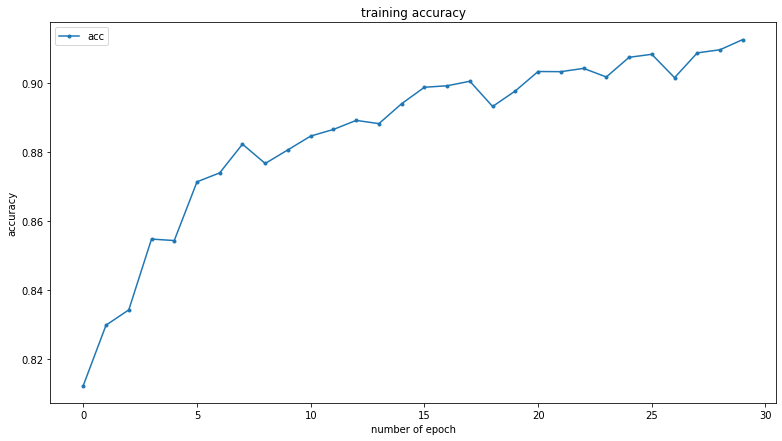

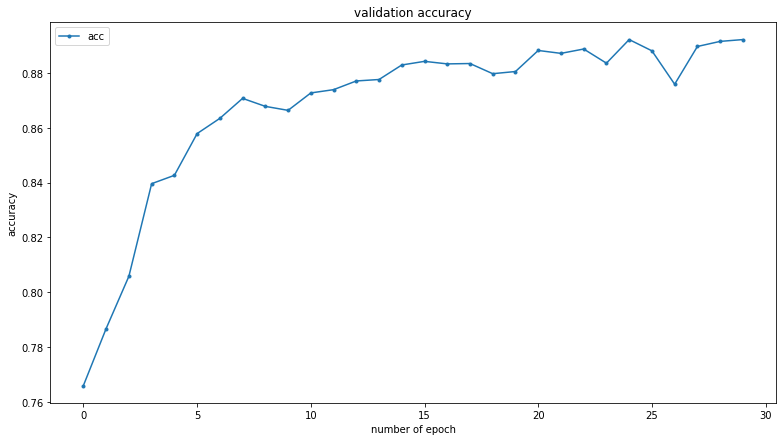

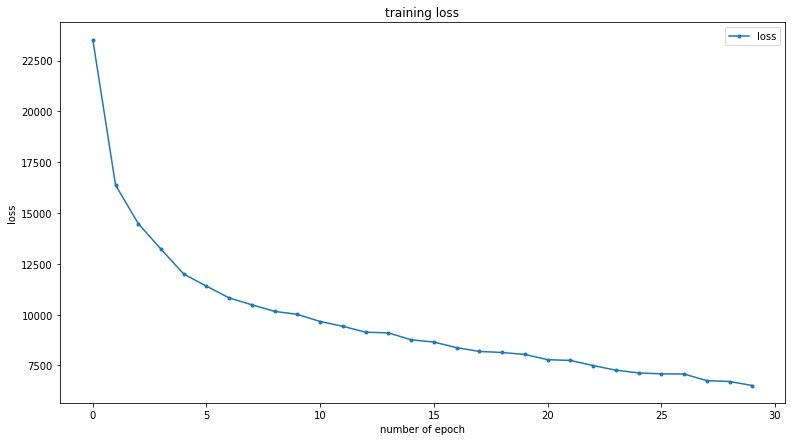

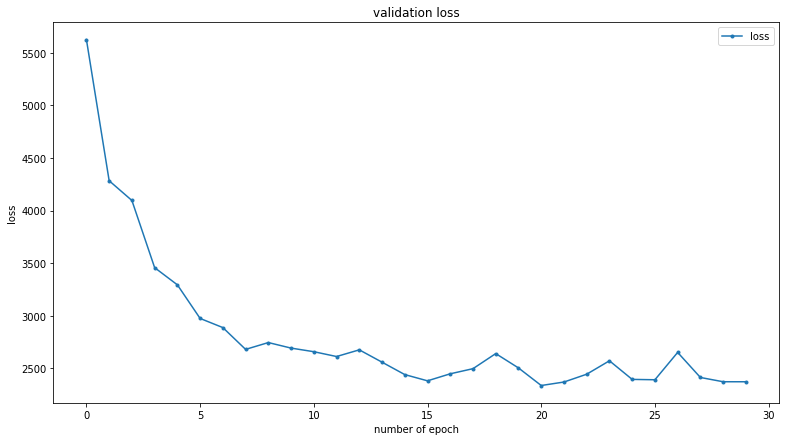

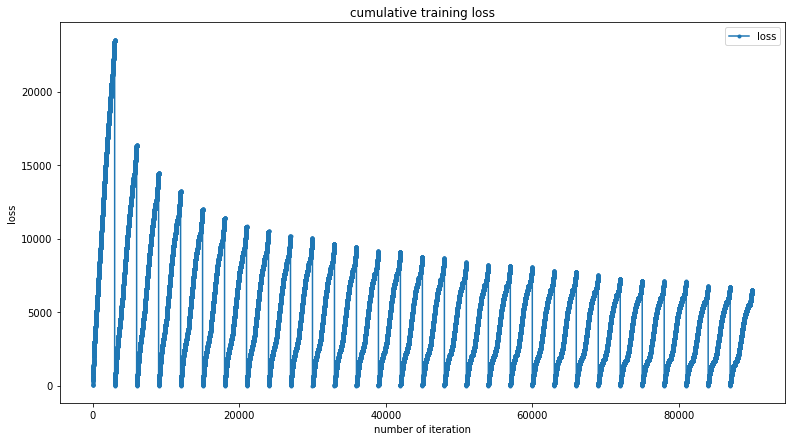

In [37]:
#### define the model########
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#### Setup input and output for the pytorch model########
input_key = 'input_word_POS_par'

train_input_index =  df_train[input_key].values
val_input_index = df_val[input_key].values

train_output_index = df_train['output_index'].values
val_output_index = df_val['output_index'].values

# there's no test output but we created a dummy output for accuracy function reuse purpose
test_input_index = df_test[input_key].values
test_output_index_dummy = [ len(test_input_index[i])*[0] for i in range(len(test_input_index))]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_DIM = len(df_train[input_key].values[0][0])


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, 'Scaled_Dot_Product',num_lstm=3).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

#use the training function to train the model
model, log_e_train_acc, log_e_val_acc, log_e_train_loss,log_e_val_loss, log_i_train_loss = train(model,epochs,train_input_index,val_input_index,train_output_index,val_output_index )
plot(log_e_train_acc, log_e_val_acc, log_e_train_loss, log_e_val_loss, log_i_train_loss)

### Validation score and Count the labels

In [38]:
y_true,y_pred,_ = cal_acc(model,val_input_index,val_output_index)

def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_ix.items()}
    return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_true_decode,y_pred_decode,digits=4))

# prediction
df_prediction = pd.DataFrame()
df_prediction['ID'] = [i for i in range(len(y_pred_decode))]
df_prediction['Predicted'] = y_pred_decode
print('prediction:')
print(df_prediction.groupby('Predicted').size().reset_index(name='counts'))
print('====================')
# true
print('true:')
df_true = pd.DataFrame()
df_true['ID'] = [i for i in range(len(y_true_decode))]
df_true['Predicted'] = y_true_decode
print(df_true.groupby('Predicted').size().reset_index(name='counts'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


              precision    recall  f1-score   support

       I-LOC     0.5906    0.8401    0.6936       419
      I-MISC     0.6119    0.2193    0.3228       187
       I-ORG     0.5976    0.1719    0.2670       285
       I-PER     0.9239    0.7074    0.8013       875
           O     0.9249    0.9810    0.9521      5790

    accuracy                         0.8921      7556
   macro avg     0.7298    0.5839    0.6074      7556
weighted avg     0.8862    0.8921    0.8789      7556

prediction:
  Predicted  counts
0     I-LOC     596
1    I-MISC      67
2     I-ORG      82
3     I-PER     670
4         O    6141
true:
  Predicted  counts
0     I-LOC     419
1    I-MISC     187
2     I-ORG     285
3     I-PER     875
4         O    5790


### Save and load the model

In [39]:
torch.save(model, 'model_9.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BiLSTM_CRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Model_10 - Baseline Model + 3layers bi-LSTM + Dependency Parsing

use attention: Scaled_Dot_Product
use number of lstm layer: 2
start training
input embeddings type: input_word_vectors
input embeddings size: 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:1, Training loss: 17457.99, train acc: 0.8665, val loss: 3129.18, val acc: 0.8530, time: 205.87s
Epoch:2, Training loss: 10921.85, train acc: 0.8866, val loss: 2600.55, val acc: 0.8792, time: 206.65s
Epoch:3, Training loss: 9538.84, train acc: 0.8944, val loss: 2445.91, val acc: 0.8842, time: 204.43s
Epoch:4, Training loss: 8758.41, train acc: 0.8996, val loss: 2312.44, val acc: 0.8886, time: 204.33s
Epoch:5, Training loss: 8154.44, train acc: 0.9043, val loss: 2213.36, val acc: 0.8954, time: 204.07s
Epoch:6, Training loss: 7643.71, train acc: 0.9079, val loss: 2170.10, val acc: 0.8970, time: 204.99s
Epoch:7, Training loss: 7203.38, train acc: 0.9104, val loss: 2150.00, val acc: 0.8989, time: 205.18s
Epoch:8, Training loss: 6802.68, train acc: 0.9125, val loss: 2144.69, val acc: 0.8997, time: 205.59s
Epoch:9, Training loss: 6430.38, train acc: 0.9137, val loss: 2140.83, val acc: 0.8997, time: 205.44s
Epoch:10, Training loss: 6084.80, train acc: 0.9166, val loss: 2125.10, val acc:

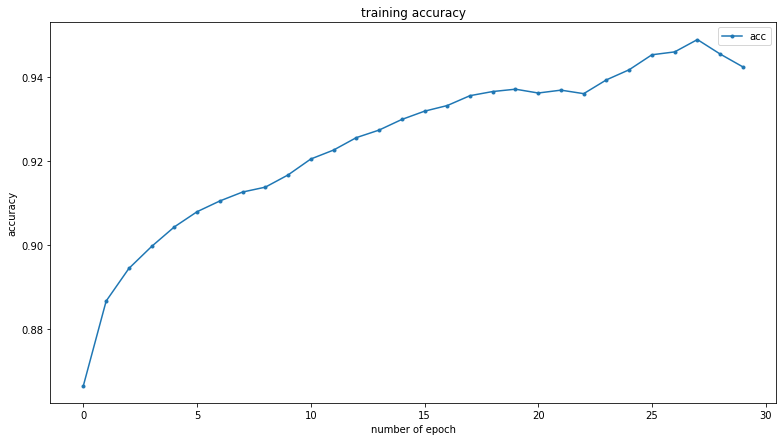

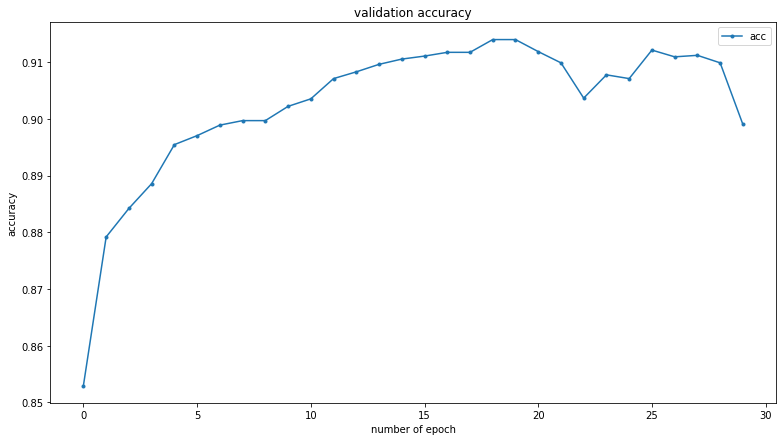

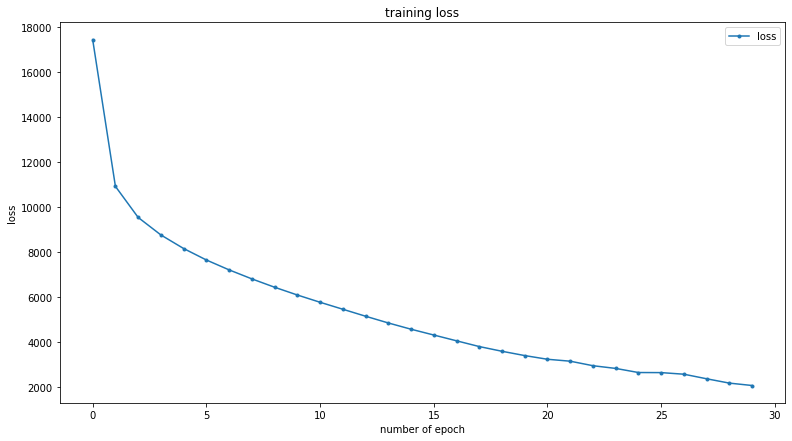

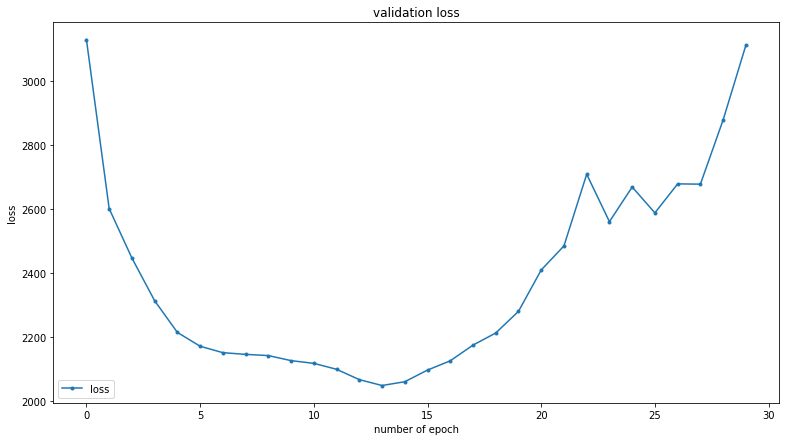

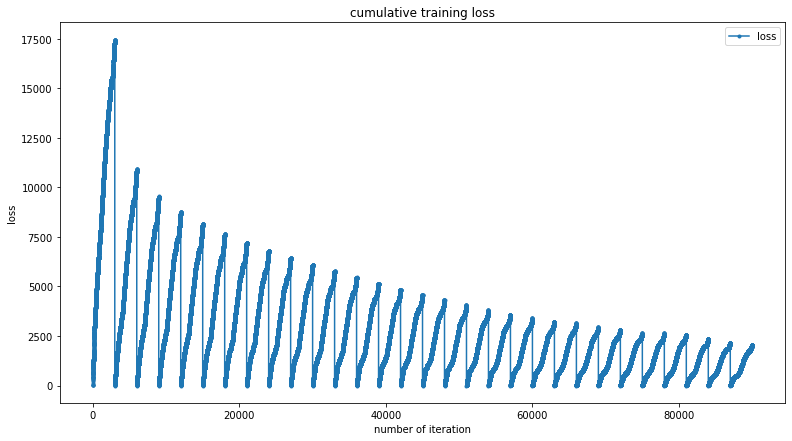

In [0]:
#### define the model########
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#### Setup input and output for the pytorch model########
input_key = 'input_word_par'

train_input_index =  df_train[input_key].values
val_input_index = df_val[input_key].values

train_output_index = df_train['output_index'].values
val_output_index = df_val['output_index'].values

# there's no test output but we created a dummy output for accuracy function reuse purpose
test_input_index = df_test[input_key].values
test_output_index_dummy = [ len(test_input_index[i])*[0] for i in range(len(test_input_index))]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
EMBEDDING_DIM = len(df_train[input_key].values[0][0])


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, 'Scaled_Dot_Product',num_lstm=3).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

#use the training function to train the model
model, log_e_train_acc, log_e_val_acc, log_e_train_loss,log_e_val_loss, log_i_train_loss = train(model,epochs,train_input_index,val_input_index,train_output_index,val_output_index )
plot(log_e_train_acc, log_e_val_acc, log_e_train_loss, log_e_val_loss, log_i_train_loss)

### Validation score and Count the labels

In [0]:
y_true,y_pred,_ = cal_acc(model,val_input_index,val_output_index)

def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_ix.items()}
    return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_true_decode,y_pred_decode,digits=4))

# prediction
df_prediction = pd.DataFrame()
df_prediction['ID'] = [i for i in range(len(y_pred_decode))]
df_prediction['Predicted'] = y_pred_decode
print('prediction:')
print(df_prediction.groupby('Predicted').size().reset_index(name='counts'))
print('====================')
# true
print('true:')
df_true = pd.DataFrame()
df_true['ID'] = [i for i in range(len(y_true_decode))]
df_true['Predicted'] = y_true_decode
print(df_true.groupby('Predicted').size().reset_index(name='counts'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


              precision    recall  f1-score   support

       I-LOC     0.7991    0.8162    0.8076       419
      I-MISC     0.5312    0.4545    0.4899       187
       I-ORG     0.3589    0.4596    0.4031       285
       I-PER     0.9387    0.6651    0.7786       875
           O     0.9448    0.9763    0.9603      5790

    accuracy                         0.8990      7556
   macro avg     0.7146    0.6744    0.6879      7556
weighted avg     0.9037    0.8990    0.8982      7556

prediction:
  Predicted  counts
0     I-LOC     428
1    I-MISC     160
2     I-ORG     365
3     I-PER     620
4         O    5983
true:
  Predicted  counts
0     I-LOC     419
1    I-MISC     187
2     I-ORG     285
3     I-PER     875
4         O    5790


### Save and load the model

In [0]:
torch.save(model, 'model_10.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BiLSTM_CRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Generate Test Score for kaggle

In [0]:
model = torch.load('model_1.pt')
model.eval()

In [0]:
y_true,y_pred,_ = cal_acc(model,test_input_index,test_output_index_dummy)

def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_ix.items()}
    return [ix_to_tag[output] for output in output_list]

y_pred_decode = decode_output(y_pred)

In [0]:
df_submission = pd.DataFrame()
df_submission['ID'] = [i for i in range(len(y_pred_decode))]
df_submission['Predicted'] = y_pred_decode

df_submission.to_csv ('Predicted_labels_model_10.txt', index = False, header=True)
df_submission

### Count the labels

In [0]:
df_submission.groupby('Predicted').size().reset_index(name='counts')